<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37 - Part 1: Data Exploration & Preprocessing</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>

---
## Table of Contents

1. [Identifying Business Needs](#1-business)
2. [Setup & Data Loading](#2-setup)
3. [Data Exploration](#3-exploration)
4. [Data Cleaning](#4-cleaning)
5. [Missing Data Treatment](#5-missing)
6. [Outlier Detection](#6-outliers)
7. [Feature Engineering](#7-features)
8. [Encoding & Scaling](#8-encoding)
9. [Export Preprocessed Data](#9-export)

---

##### **Abstract**

This project was developed for **Cars 4 You** to accelerate their car evaluation process, which is currently slowed by manual inspections and leads potential sellers to competitors. The primary goal was to build a **robust regression model** to accurately predict a car's resale price based on seller-provided features. Due to the presence of outliers, the modeling focus was set on **predicting the median price**, using the **Mean Absolute Error (MAE)** as the primary loss function, which aligns with the **Kaggle competition's metric**.

The methodology began with extensive **data preprocessing**, including cleaning categorical inconsistencies using **fuzzy matching** and a validated dictionary built with the **wheel-size.com API**. Logical errors like negative numerical values were corrected, and missing data was imputed using  **MICE** for MAR variables. Predictive power was enhanced by **engineering features** like *age* and *miles per year*. 

High-cardinality categorical variables were encoded using smoothed Target Encoding to capture their direct relationship with price. Low-cardinality categories were one-hot encoded. All features were normalised with a **PowerTransformer**  (Yeo-Johnson) to achieve near-Gaussian distributions, seeking to optimize the performance across the algorithms selected.

Feature selection combined **business-driven exclusions** (e.g., removal of paintQuality% and near-zero variance features such as hasDamage) with **data-driven filters** (Spearman correlation analysis) and **model-based importance ranking** from the individual algorithms. 

 Holdout validation strategy (80/20 split) was used to evaluate the models. The primary metric was Mean Absolute Error (MAE) as it directly represents the average prediction error in pounds. 
 Hyperparameter tuning via grid search was performed on multiple regression algorithms. The top-performing individual models were **Gradient Boosting**, **Random Forest**, and **KNeighbors Regressor**. 

 To further improve robustness and predictive accuracy, a **Stacking Ensemble** was built using these three models as base learners, with a **Ridge Regressor** as the meta-learner and 5-fold cross-validation for blending. The target variable was transformed using **log1p** during training to mitigate the impact of high-price outliers, with predictions inverted via **expm1** at inference time. The final stacked ensemble, achieved a **validation MAE of approximately X** 


##### **Group Contribution**

| Member | Main Contributions | Contribution |
|:-------|:--------------------|:-------------:|
| **Filipa** | Data Cleaning,  Feature Engineering, Feature Selection, Model Training | **40%** |
| **Gonçalo** | Exploratory Data Analysis, some Data Cleaning, Report Writing | **15%** |
| **Marta** | API request, Utils, Data Cleaning, Feature Engineering| **30%** |
| **Tomás** | Exploratory Data Analysis, some Data Cleaning, Report Writing | **15%** |


<a id='1-business'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>1 | Identifying Business Needs</b></span>
    </h1>
</div>

**Overview and main goals.**    
**Cars 4 You** is an online car resale company that buys vehicles from multiple brands and resells them for profit. Increasing demand has created long waiting lists for mechanic inspections, delaying purchases and driving customers to competitors. To address this, the company aims to develop a **predictive model that estimates car prices from user-provided information**, eliminating the need for prior inspection.    

This project focuses on building a reliable and interpretable regression model to predict car prices based on user inputs, streamlining the evaluation process through effective data exploration and preprocessing.

**Available Attributes:**

|       | **Attribute**      | **Description**                                                                  |
|-------|-------------------|---------------------------------------------------------------------------------|
| **0** | `carID`           | Unique identifier for each car                                                  |
| **1** | `Brand`           | The car's main brand (e.g. Ford, Toyota)                                        |
| **2** | `model`           | The car model                                                                   |
| **3** | `year`            | The year of registration of the car                                             |
| **4** | `transmission`    | Type of transmission (Manual, Automatic, Semi-Auto, Other)                      |
| **5** | `mileage`         | Total reported distance travelled by the car (in miles)                         |
| **6** | `fuelType`        | Type of fuel used (Diesel, Petrol, Hybrid, Electric)                            |
| **7** | `tax`             | Road tax applicable in 2020 (in £)                                              |
| **8** | `mpg`             | Average Miles per Gallon                                                        |
| **9** | `engineSize`      | Size of engine in liters                                                        |
| **10**| `paintQuality%`   | Mechanic's assessment of paint quality (0-100%)                                 |
| **11**| `previousOwners`  | Number of previous registered owners                                            |
| **12**| `hasDamage`       | Boolean indicating if the car is damaged                                        |
| **13**| `price`           | The car's price when purchased by Cars 4 You (in £) — **TARGET**               |


</div  >

 <b>Note:</b> The variable `transmission` is not presented in the metadata but we will consider it as type of transmission of the car (Automatic, Manual, Semi-Automatic, Other).
  <div style="background-color:#e5c120ff; padding:1px; border-radius:10px;">
</div>

<a id='2-setup'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2 | Setup & Data Loading</b></span>
    </h1>
</div>

### 2.1 Import Libraries

In [388]:
# Standard Libraries
import random
import warnings
from math import ceil
from itertools import combinations
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Statistics
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency, f_oneway

# Machine Learning
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import (
    OneHotEncoder, RobustScaler, MinMaxScaler, 
    PowerTransformer, StandardScaler, TargetEncoder
)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold

# Custom utilities
import utils

# Configuration
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")

# Plot styling
plt.style.use("ggplot")
sns.set_theme(style="white")
%config InlineBackend.figure_format = 'retina'

# Reproducibility
RANDOM_STATE = 37
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Custom color palette
palette = sns.color_palette("YlOrBr", 10)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


### 2.2 Load Data

In [389]:
# Load training and test datasets
car_eval = pd.read_csv('./project_data/train.csv')
X_test = pd.read_csv('./project_data/test.csv')

# Load brand/model reference dictionary (from wheel-size API)
#run_cars_api_request() #lets keep this function commented because it takes 2 hours running due to the API limit
brand_model_dic = pd.read_csv('./project_data/brands_models.csv')

print(f"Training set: {car_eval.shape[0]:,} rows, {car_eval.shape[1]} columns")
print(f"Test set: {X_test.shape[0]:,} rows, {X_test.shape[1]} columns")
print(f"Brand/Model reference: {brand_model_dic.shape[0]:,} entries")

Training set: 75,973 rows, 14 columns
Test set: 32,567 rows, 13 columns
Brand/Model reference: 5,891 entries


<a id='3-exploration'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>3 | Data Exploration</b></span>
    </h1>
</div>

### 3.1 Data Overview

In [390]:
# Preview training data
car_eval.head()

carID   Brand      model    year  price transmission  mileage fuelType  \
0  69512      VW       Golf 2016.00  22290    Semi-Auto 28421.00   Petrol   
1  53000  Toyota      Yaris 2019.00  13790       Manual  4589.00   Petrol   
2   6366    Audi         Q2 2019.00  24990    Semi-Auto  3624.00   Petrol   
3  29021    Ford     FIESTA 2018.00  12500        anual  9102.00   Petrol   
4  10062     BMW   2 Series 2019.00  22995       Manual  1000.00   Petrol   

     tax   mpg  engineSize  paintQuality%  previousOwners  hasDamage  
0    NaN 11.42        2.00          63.00            4.00       0.00  
1 145.00 47.90        1.50          50.00            1.00       0.00  
2 145.00 40.90        1.50          56.00            4.00       0.00  
3 145.00 65.70        1.00          50.00           -2.34       0.00  
4 145.00 42.80        1.50          97.00            3.00       0.00

> By observing just a few rows, we can already identify both categorical and numerical variables. Since categorical variables are present, we know that some type of encoding will be required before using them in the model. Some of the numerical variables (like `year` and `previousOwners`) should not be treated as continuous. It is also noticeable that there are missing values, at least in the variable `tax`. Additionally, there are some spelling errors and inconsistencies in text formatting, such as differences in lowercase and uppercase (ex: `transmission` includes both "Manual" and "anual").
</div>

In [391]:
# Data types and missing values
car_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


> The train and test datasets contain the same variables, except for the target variable `price`, as expected. The data types are consistent across both datasets, however, some issues are present. <BR><BR>
The training set contains 75,973 records and all variables have missing values except for the identifier `carID` and the target variable `price`.
The test set contains 32,567 records and also shows missing values in all variables except for the identifier `carID`. <BR><BR>
Moreover, it can be noted that the variables `year` and `previousOwners` should indeed be numeric, but of integer type (int64) rather than continuous (float64). The variable `hasDamage` should be boolean, as a car either has damage or it does not. Finally, `carID` should be categorical, but since it is a unique identifier and will not be used in the model, there is no need to modify its data type.



In [392]:
# Check for duplicates
utils.print_dup_info(car_eval, exclude_groups=[['carID'], ['price', 'carID']], name="Training Set")
utils.print_dup_info(X_test, exclude_groups=[['carID']], name="Test Set")

Total duplicates in Training Set: 0
Duplicates without carID in Training Set: 4
Duplicates without price and carID in Training Set: 11
Total duplicates in Test Set: 0
Duplicates without carID in Test Set: 0


> We can see that although there are no duplicates when considering all columns, there are 4 duplicates in the training set when the `carID` column is excluded. We consider these true duplicates and therefore we will remove them (two different cars are unlikely to have exactly the same features). <br><br>
Additionally, there are more 7 duplicates when excluding both `carID` and `price`. Since `carID` is only an identifier and not an input variable, having identical inputs with different target values would confuse the model; there would be no apparent reason for predicting different prices. This increases noise and reduces the model’s generalization ability, so we will keep only the most recent submission for each car.

In [393]:
# Remove duplicates (excluding carID and price from duplicate check)
car_eval = car_eval.drop_duplicates(
    subset=car_eval.columns.difference(['carID', 'price']).tolist(), 
    keep='last'
)
print(f"Training set after removing duplicates: {car_eval.shape[0]:,} rows")

# Set carID as index
car_eval = car_eval.set_index('carID')
X_test = X_test.set_index('carID')

Training set after removing duplicates: 75,962 rows


### 3.2 Descriptive Statistics

In [394]:
# Numeric variables - extended statistics with skewness and kurtosis
utils.describe_num_with_skew_kurtosis(car_eval)

count     mean      std       min      25%      50%  \
year           74471.00  2017.10     2.21   1970.00  2016.00  2017.00   
price          75962.00 16882.24  9737.28    450.00 10200.00 14699.00   
mileage        74500.00 23006.39 22130.27 -58540.57  7426.00 17303.00   
tax            68060.00   120.33    65.52    -91.12   125.00   145.00   
mpg            68038.00    55.15    16.50    -43.42    46.30    54.30   
engineSize     74446.00     1.66     0.57     -0.10     1.20     1.60   
paintQuality%  74438.00    64.59    21.02      1.64    47.00    65.00   
previousOwners 74412.00     1.99     1.47     -2.35     1.00     2.00   
hasDamage      74414.00     0.00     0.00      0.00     0.00     0.00   

                    75%       max  skew  kurtosis  
year            2019.00   2024.12 -1.85     11.80  
price          20950.00 159999.00  2.28     12.00  
mileage        32432.25 323000.00  1.55      5.23  
tax              145.00    580.00  0.05      3.56  
mpg               62.80    470.80  7.30    158.66  
engineSize         2.00      6.60  1.23      4.44  
paintQuality%     82.00    125.59 -0.01     -0.77  
previousOwners     3.00      6.26 -0.00     -0.85  
hasDamage          0.00      0.00  0.00      0.00

In addition to the insights drawn so far from the numerical variables in the training dataset, we can further highlight:
- **`year`**: has a distribution centered around 2017, indicating that most cars in the dataset are relatively recent (from 2016 onwards). The minimum value of 1970 reveals a few much older vehicles. The negative skewness (-1.85) confirms a concentration of newer models, with a long left tail representing these rare older cars. The high kurtosis (11.8) further suggests a narrow and peaked distribution with extreme values, reinforcing that while some cars are old, the vast majority belong to modern years.

 - **`price`**: has a mean of around 16,882 with considerable dispersion (std ≈ 9,737). About 75% of cars cost up to roughly 20,950, while the maximum price reaches nearly 160,000, indicating the presence of some luxury vehicles. The positive skew (2.28) shows a strongly right-skewed distribution, with most cars priced lower but a few extremely high values. The high kurtosis (12.0) further highlights a long-tailed distribution with notable outliers at the upper end.

- **`mileage`**: shows an average of around 23,000 miles with considerable dispersion (standard deviation ≈ 22,130), reflecting the diversity in vehicle usage. The quartiles indicate that 50% of cars have between approximately 7,400 and 32,400 miles, typical of relatively recent vehicles with regular use. The positive skewness (1.55) shows that most vehicles have low to moderate mileage, while a few have very high values. The kurtosis (5.23) confirms the presence of some outliers. The negative minimum value (-58,540) is unrealistic and will be corrected, although it does not substantially alter the overall pattern of the variable.
<!-- affecting the mean, standard deviation, and the lower tail. Despite this, the positive skew (1.56) indicates that most cars have moderate mileage, with a few high-mileage outliers -->

- **`tax`**: has an average of around £120, with values mostly concentrated between £125 and £145 (25th and 75th percentiles), suggesting that most cars fall within similar tax bands, typical of low- to mid-emission vehicles. The dispersion is moderate (std ≈ 66), and the near-zero skewness (0.05) indicates an approximately symmetric distribution, further supported by the kurtosis (3.56) close to normality. The negative value (-91.12) is logically impossible and slightly affects the symmetry of the distribution. We will treat or remove it to prevent bias in further analyses and predictive models.

- **`mpg`**: has an average of about 55 mpg, with most values ranging between 46 and 63 mpg, reflecting a dataset dominated by vehicles with fuel efficiency typical of modern cars. However, the strong right skewness (7.30) and extremely high kurtosis (158.66) indicate the presence of severe outliers that should be carefully examined. The negative minimum (-43.42) is physically impossible and should be removed. If not properly treated, this variable could distort its relationship with `price` in the final model and harm predictive performance.

- **`engineSize`**: presents a realistic distribution, with an average of 1.66L and most vehicles between 1.2L and 2.0L. The positive skewness (1.23) and slightly high kurtosis (4.44) indicate a few cars with larger engines, up to 6.6L. The negative minimum value (-0.1)  is technically impossible and may slightly influence the positive skew.

- **`paintQuality%`**: presents a balanced distribution (skew ≈ 0, kurtosis ≈ -0.8), suggesting values are spread almost symmetrically around the mean (64.6). Most cars have paint quality between 47% and 82%, with few extreme values. This variable seems approximately normal, with moderate dispersion (std = 21.0). The maximum value (125.59%) is unrealistic for a percentage scale.

- **`previousOwners`**: displays a symmetric distribution (skew ≈ 0), centered around 2 previous owners on average, with most cars having between 1 and 3 owners. Kurtosis is slightly negative (-0.85), indicating a flatter-than-normal shape (less concentration around the mean). The negative minimum value (-2.35) is clearly invalid, and after removing these negative entries, the distribution is expected to approximate a normal shape.

- **`hasDamage`**: this analysis is not strictly appropriate, since the variable is binary (though its type has not yet been converted). Nonetheless, we can see no variation, all values are 0. This makes the variable meaningless in its current form, as it should be boolean (0 = no damage, 1 = damaged). Since the “1” category never appears, the feature provides no analytical value. It could be removed from the model, although we will further investigate its origin.


In [395]:
# Categorical variables
utils.describe_cats(car_eval)

count unique     top   freq top_freq_ratio
Brand         74441     72    Ford  14806           0.20
model         74445    735   Focus   6351           0.09
transmission  74440     40  Manual  38042           0.51
fuelType      74451     34  Petrol  37985           0.51

Regarding the test set in comparison with the previously analyzed training set:
- **`year`**: maintains almost the same distribution, with an identical mean and equal interquartile ranges, but with a higher minimum value (1991 vs. 1970), indicating the absence of the oldest vehicles in the test set. The lower skewness (-1.61 vs. -1.85) and kurtosis (6.81 vs. 11.8) suggest a slightly less concentrated distribution with fewer extreme values.

- **`mileage`**: shows values that are nearly identical, including the same impossible negative minimum, showing that the same type of measurement error persists. However, there is a slight reduction in skewness (1.49 vs. 1.55) and kurtosis (4.46 vs. 5.23), suggesting a somewhat more balanced distribution.

- **`tax`**: exhibits an almost identical distribution between the two datasets, again including the invalid negative value. Both the mean and quartiles are nearly the same, indicating structural consistency in the test set. Minor variations in skewness (0.08 vs. 0.05) and kurtosis (3.74 vs. 3.56) are not significant.

- **`mpg`**: although the central statistics remain identical, the test set shows greater dispersion (std 17.64 vs. 16.50), higher skewness (8.76 vs. 7.30), and even higher kurtosis (186.44 vs. 158.66), reflecting a stronger presence of extreme values. The negative values remain and must be corrected, as they significantly influence the distribution and may harm the performance of the price prediction model.

- **`engineSize`**: behaves almost identically to the training set, with similar mean and dispersion. The slight decrease in skewness (1.18 vs. 1.23) and kurtosis (3.93 vs. 4.44) indicates a marginally more homogeneous distribution in the test set.

- **`paintQuality%`**: shows very similar distributions across both datasets. The means (≈64.5) and quartiles remain practically unchanged, as do the shape measures (skewness and kurtosis near zero), demonstrating stability and good representativeness of this variable between training and testing.

- **`previousOwners`**: has nearly identical values, including the same impossible negative minimum (-2.35). The means (≈2) and quartiles match, and the distribution remains symmetric, confirming consistency across datasets, although the negative anomaly still needs correction. 

- **`hasDamage`**: continues to show no variation, containing only zeros in both datasets. The recommendation stands where its source should be reviewed, and its removal from the model should be considered.



### 3.3 Data Visualizations

In [396]:
# Identify column types
num = car_eval.select_dtypes(include='number').columns
cat = car_eval.select_dtypes(exclude='number').columns

print(f"Numeric columns ({len(num)}): {list(num)}")
print(f"Categorical columns ({len(cat)}): {list(cat)}")

Numeric columns (9): ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
Categorical columns (4): ['Brand', 'model', 'transmission', 'fuelType']


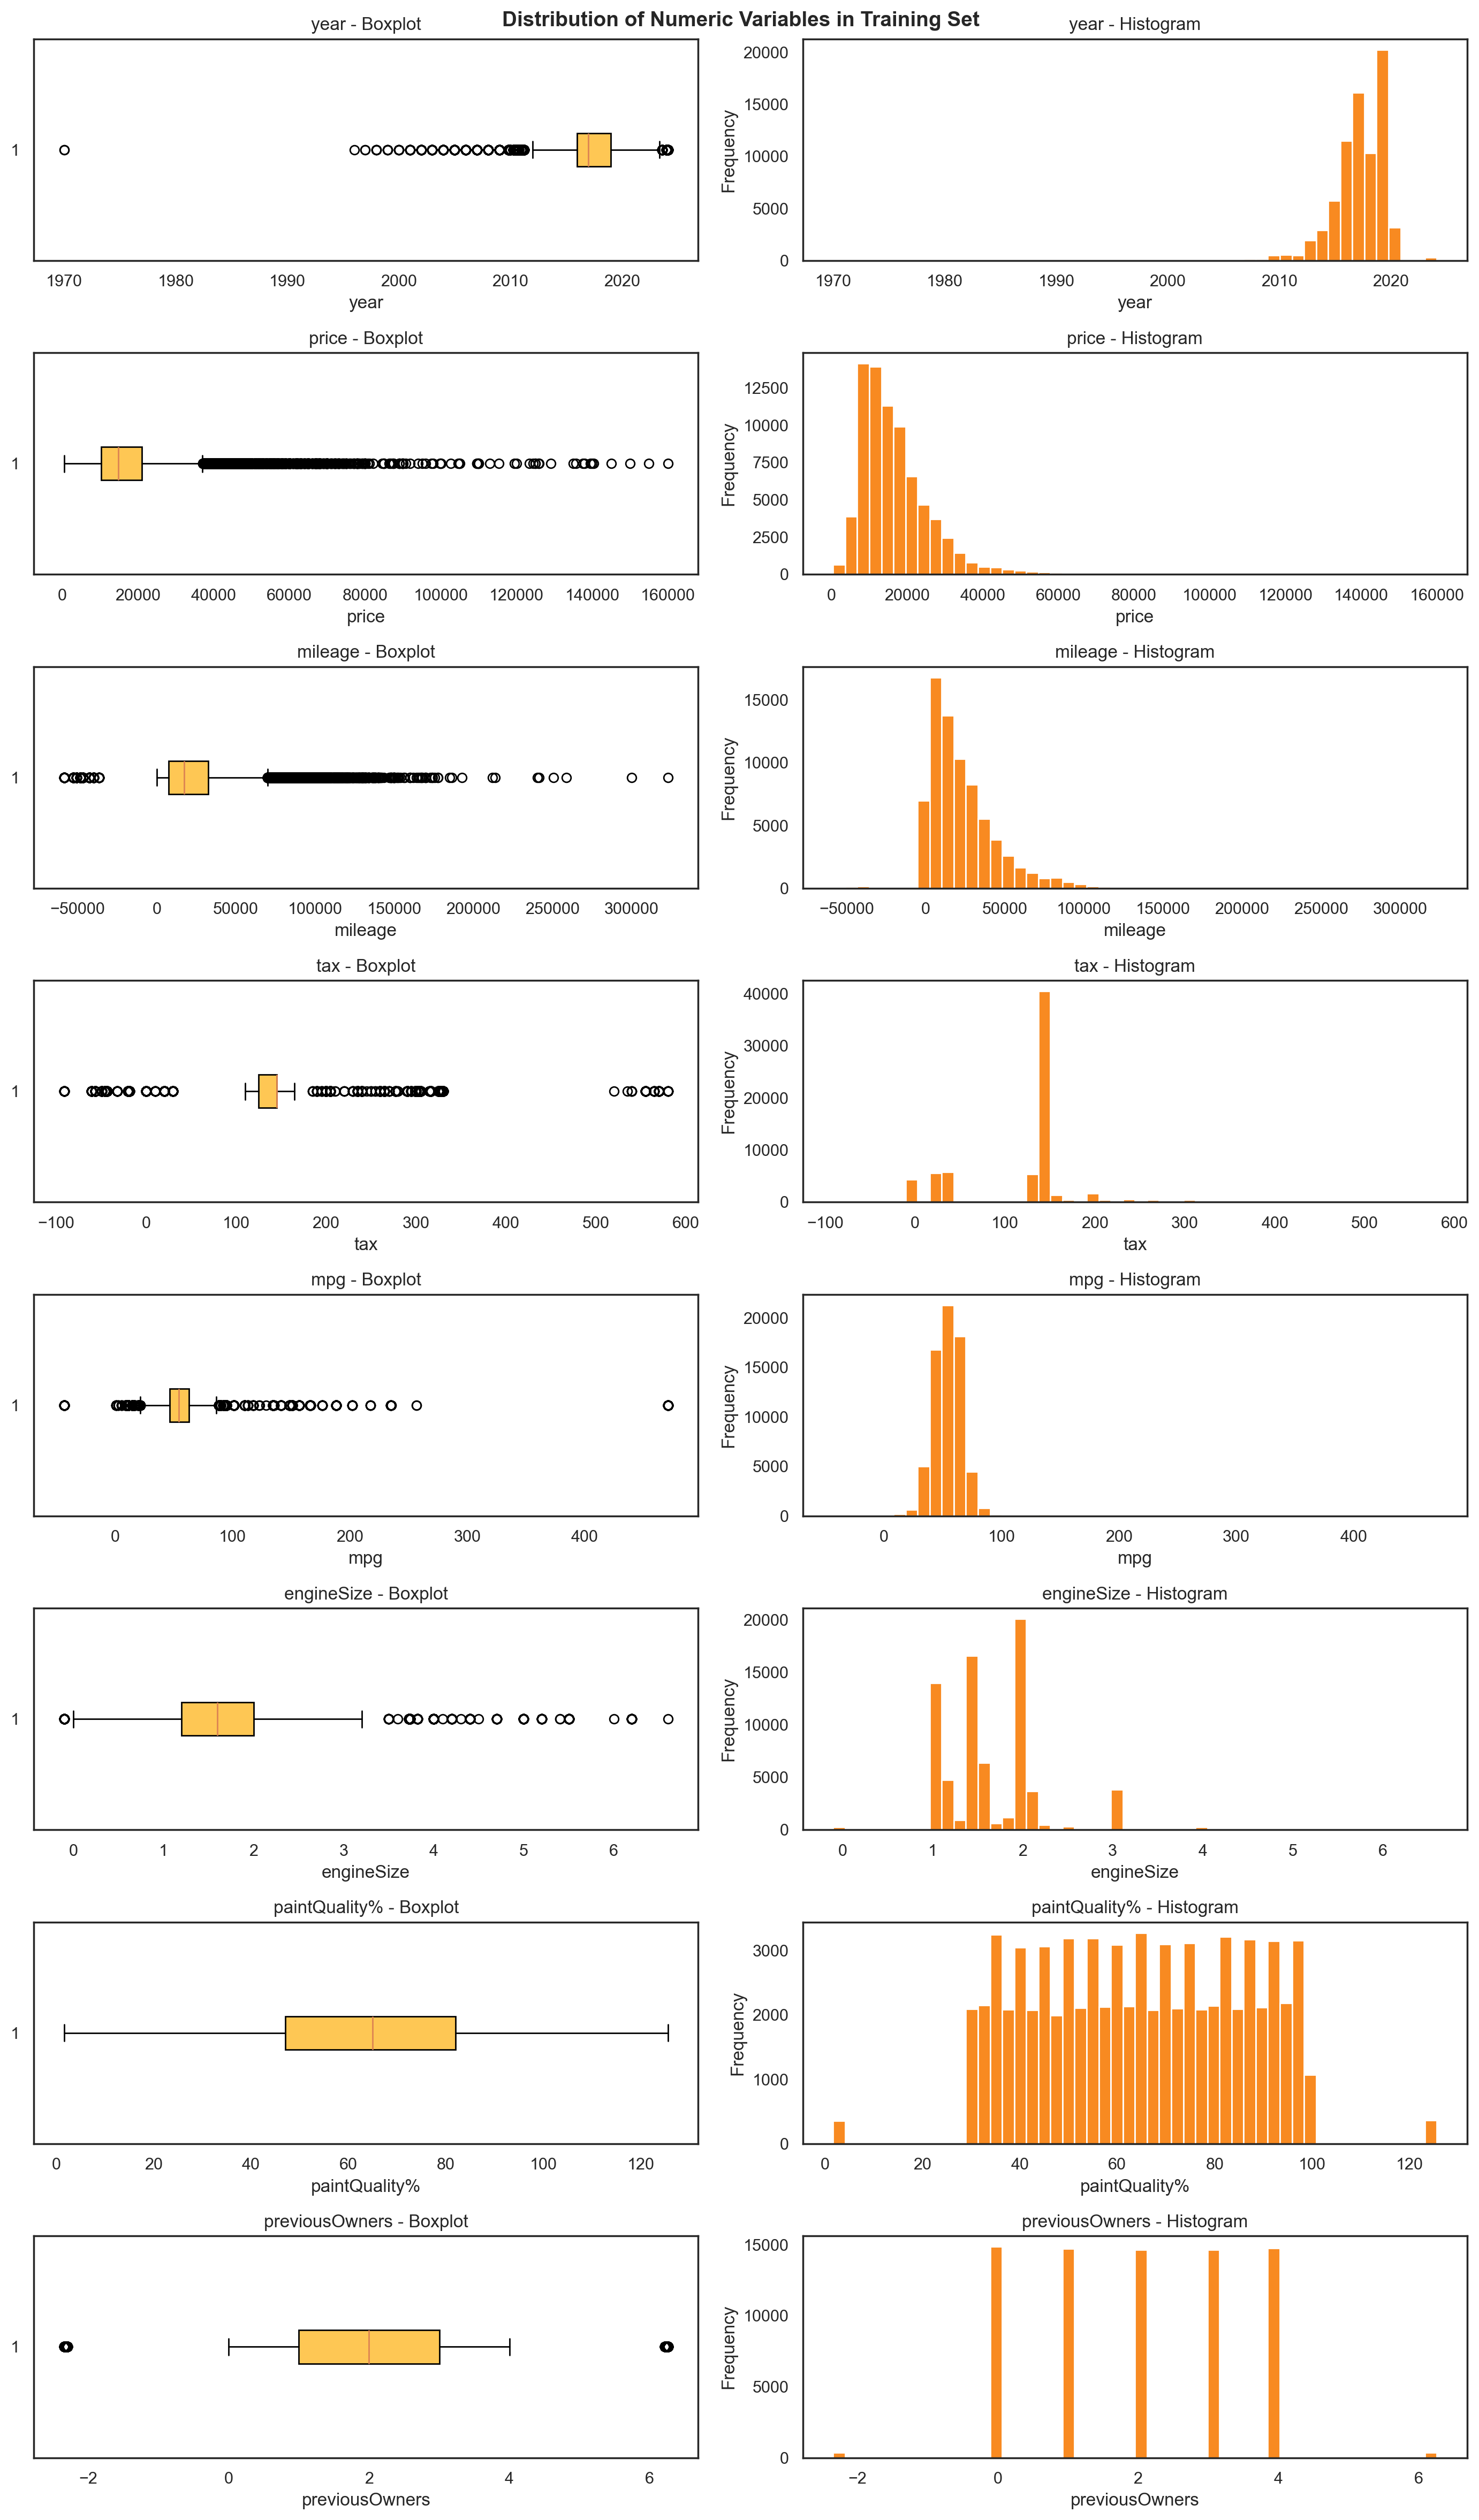

In [397]:
def plot_box_hist(df, cols, title, n_bins=50):
    """Plot boxplots and histograms for numeric variables."""
    n = len(cols)
    fig, axes = plt.subplots(n, 2, figsize=(14, 3*n))
    
    for i, col in enumerate(cols):
        # Boxplot
        axes[i, 0].boxplot(df[col].dropna(), vert=False, patch_artist=True,
                          boxprops=dict(facecolor=palette[3]))
        axes[i, 0].set_title(f'{col} - Boxplot')
        axes[i, 0].set_xlabel(col)
        
        # Histogram
        axes[i, 1].hist(df[col].dropna(), bins=n_bins, color=palette[5], edgecolor='white')
        axes[i, 1].set_title(f'{col} - Histogram')
        axes[i, 1].set_xlabel(col)
        axes[i, 1].set_ylabel('Frequency')
    
    plt.suptitle(f'Distribution of Numeric Variables {title}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot numeric distributions (excluding binary variables)
plot_box_hist(car_eval, num.drop(['hasDamage']), "in Training Set")

- **`Year`**: The distribution for year is left-skewed, characterized by a long tail towards older models, with the vast majority of vehicles clustered in the 2010-2020 range as noted previously. The outliers represent mainly the oldest vehicles, extending down towards 1970.

- **`Price`**: The price distribution exhibits a notable positive skew, with a large number of vehicles concentrated at lower price points and a long tail extending significantly towards very high prices, which pulls the mean above the median. The visible outliers are these high-priced vehicles stretching past 40,000.

- **`Mileage`**: As established, mileage shows a positive skew, concentrating most vehicles under 60,000 miles while having a long tail for higher mileages. Crucially, the outliers on the far left clearly show the presence of negative mileage values, confirming the existence of this error as noted before.

- **`Tax`**: The tax variable displays a bimodal distribution. We observe the presence of invalid negative outliers, as noted earlier, as well as several high-end outliers. This indicates that while the bulk of the data is clustered within specific ranges, the distribution still extends toward the extreme upper end.

- **`MPG`**: The Miles Per Gallon variable is characterized by a strong positive/right skew (mean > median),  with most of the data clustering in the lower-to-mid range MPG values and a long, thin tail extending towards higher MPG values, contributing to the presence of several right-side outliers. It also shows visible negative outliers, which are non-physical and will be addressed.

- **`EngineSize`**: The engineSize plot presents a multimodal distribution, clearly showing distinct groups, likely corresponding to common engine displacements (e.g., peaks near 1, 1.5, and 2 liters). This variable shows a positive skew with some outliers on the higher end, as well as a negative outlier that is not physically possible.

- **`PaintQuality%`**: The paintQuality% distribution is exceptionally stable and appears nearly uniform across the central range (approximately 30% to 90%). The shape measures being near zero (skew≈0 and kurtosis≈0) are visually evident in this flat distribution, and it does not show any outliers.

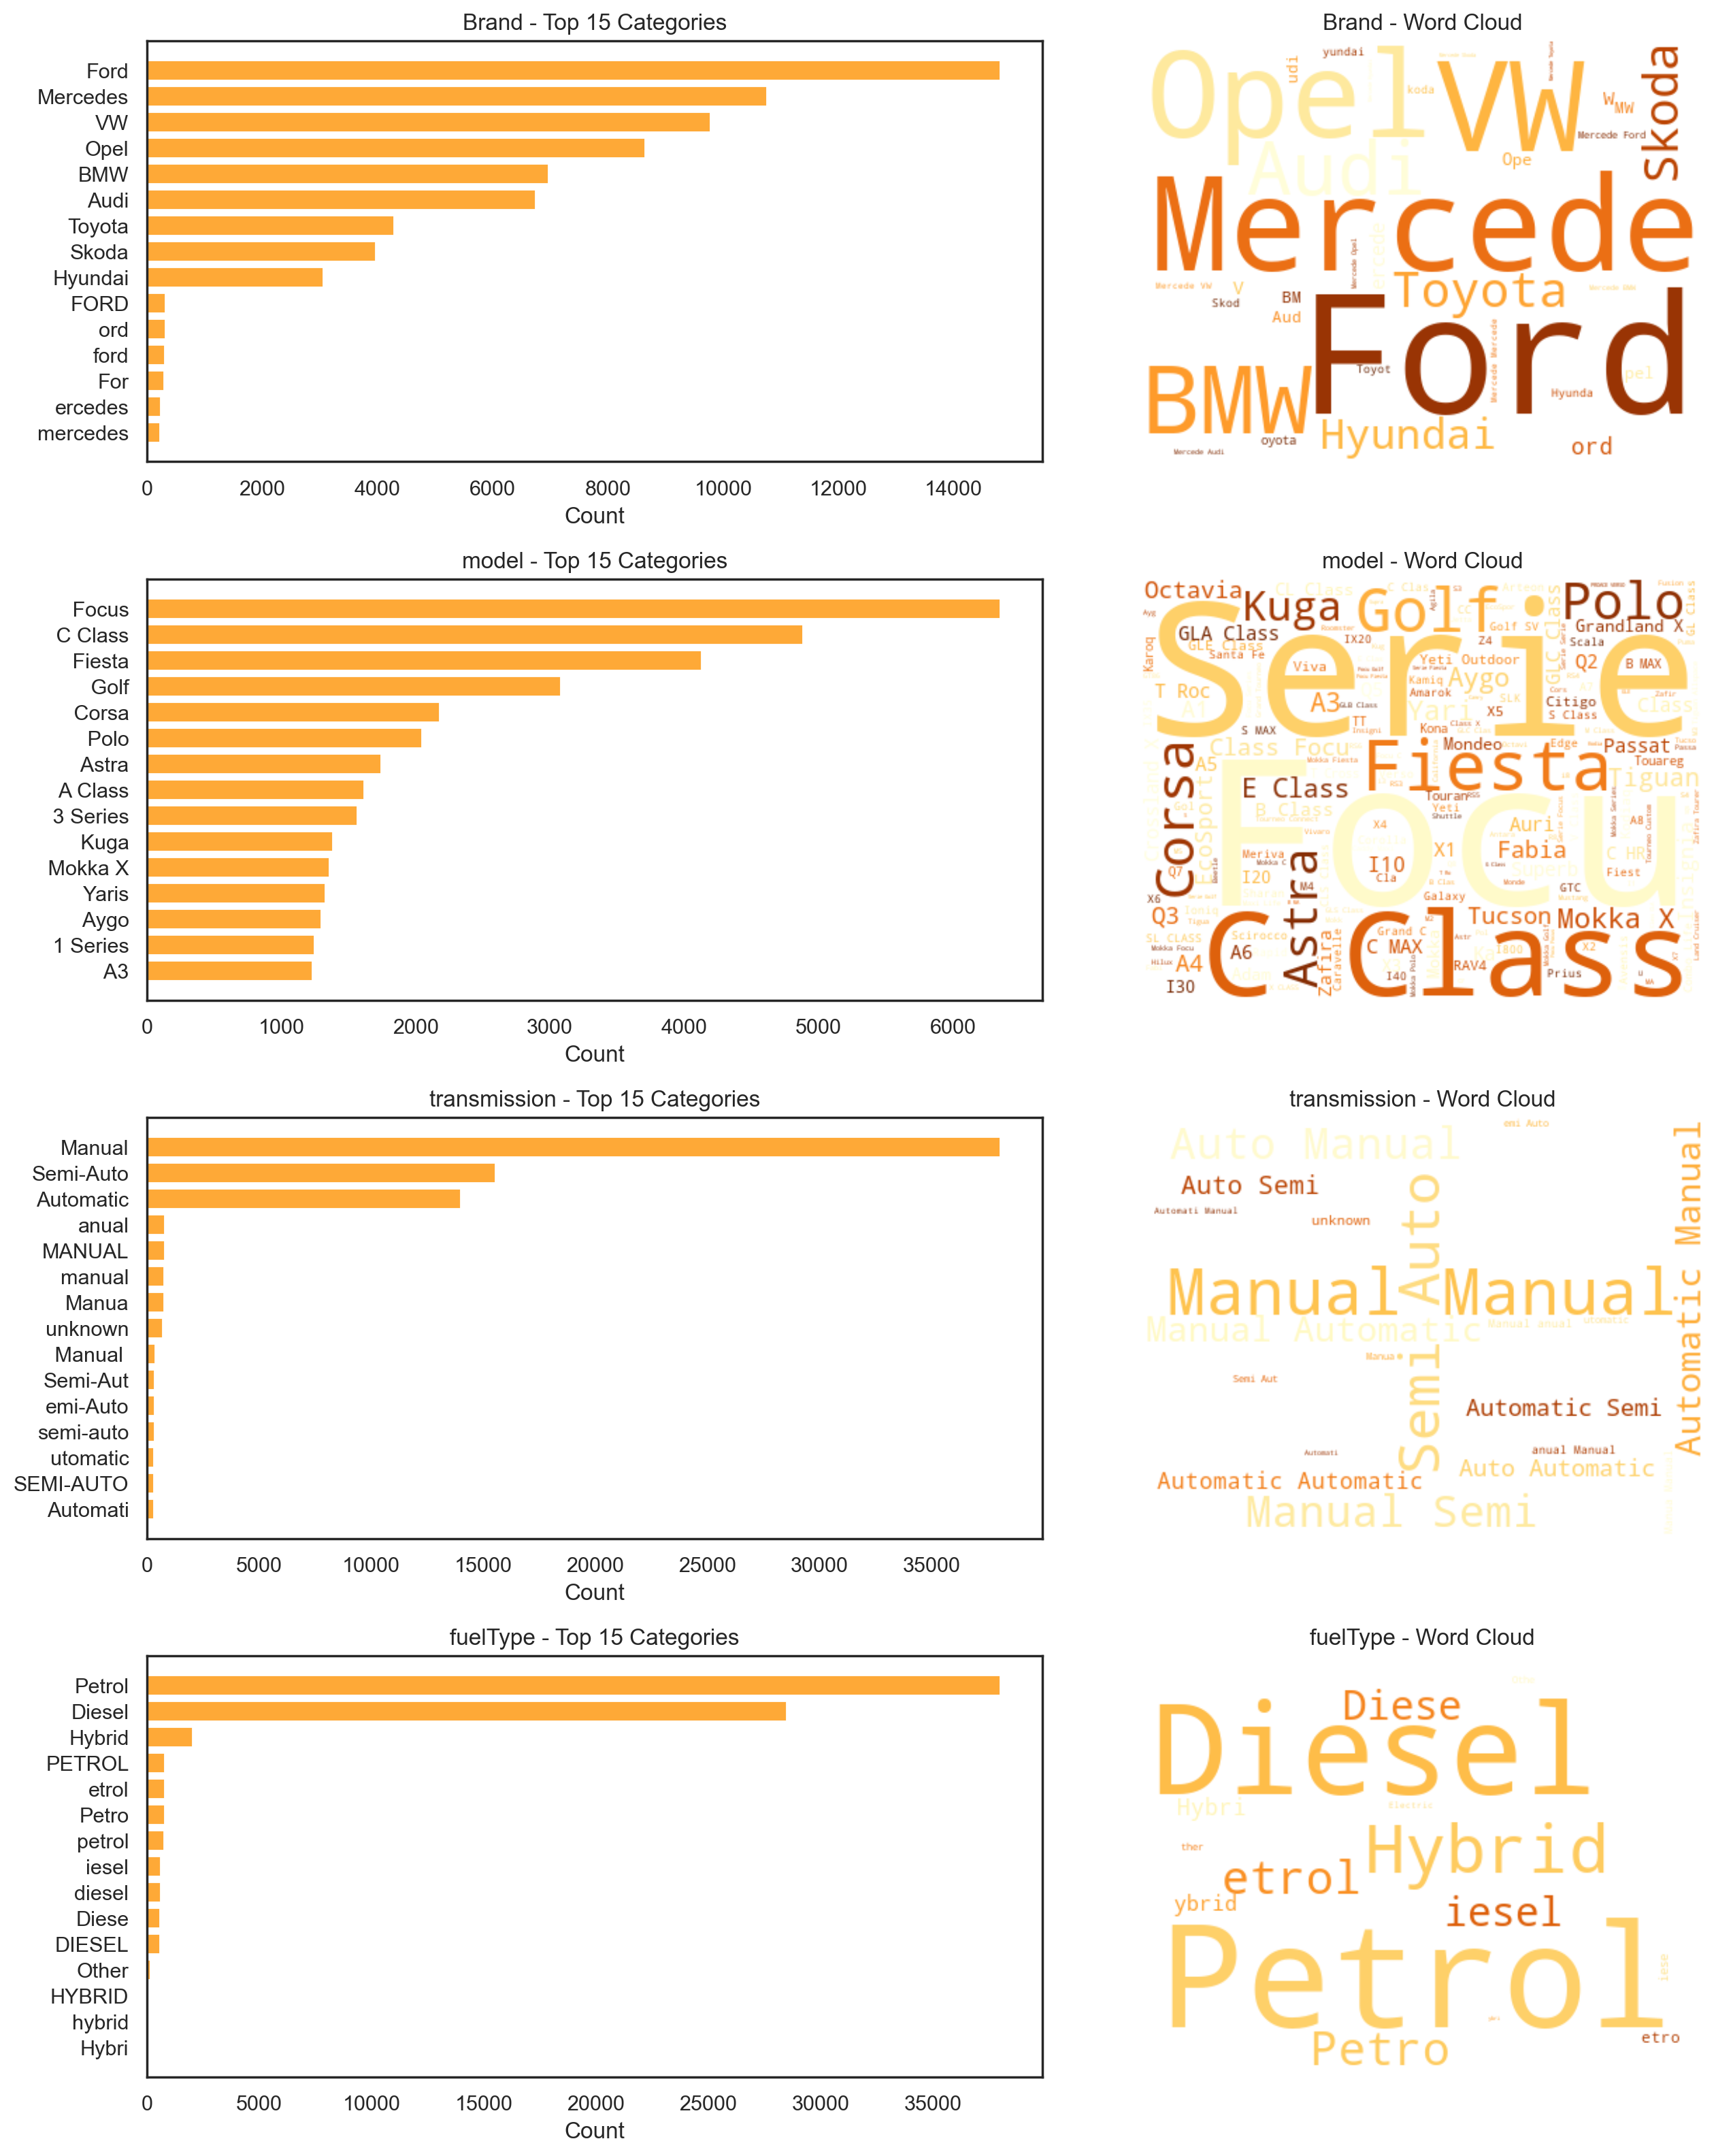

In [398]:
def plot_bar_wordcloud(df, cols):
    """Plot bar charts and word clouds for categorical variables."""
    n = len(cols)
    fig, axes = plt.subplots(n, 2, figsize=(14, 4*n))
    
    if n == 1:
        axes = axes.reshape(1, -1)
    
    for i, col in enumerate(cols):
        counts = df[col].value_counts()
        
        # Bar chart
        axes[i, 0].barh(counts.index[:15], counts.values[:15], color=palette[4])
        axes[i, 0].set_title(f'{col} - Top 15 Categories')
        axes[i, 0].set_xlabel('Count')
        axes[i, 0].invert_yaxis()
        
        # Word cloud
        text = ' '.join(df[col].dropna().astype(str))
        wordcloud = WordCloud(width=400, height=300, background_color='white',
                             colormap='YlOrBr').generate(text)
        axes[i, 1].imshow(wordcloud, interpolation='bilinear')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'{col} - Word Cloud')
    
    plt.tight_layout()
    plt.show()

# Plot categorical distributions
plot_bar_wordcloud(car_eval, cat)

- **`Brand`**: the 3 brands with the highest presence in the training set are `Ford` (19.9%), `Mercedes` (14.4%), and `VW` – Volkswagen (13.1%). However, by examining the word cloud, we can see that there are many spelling errors and inconsistencies (e.g., `Opel`, `opel`, `pel`, `OPEL`). We were already aware that these issues existed, but this visualization provides a better understanding of the problem, as it could be affecting the order in which the brands appear. It will be more insightful to compare these results with those obtained after correcting inconsistencies across all variables.

- **`model`**: The most common car models are `Focus` (8.5%) from Ford, `C Class` (6.6%) from Mercedes, and `Fiesta` (5.5%) from Ford, corresponding to the most frequent car brands. There are many different car models, which makes it difficult to determine whether the same inconsistencies observed in the brand variable are present here, though this possibility cannot be ruled out.

- **`transmission`**: The most frequent transmission type is `Manual` (51.1%), followed by `Semi-Auto` (20.9%) and `Automatic` (18.8%). The word cloud reveals several spelling errors and inconsistencies, such as `anual`, `MANUAL`, and `manual`, which is affecting the statistics.

- **`fuelType`**: The most common fuel type is `Petrol` (51.0%), followed by `Diesel` (38.2%), with a sharp drop to `Hybrid` (2.7%). The word cloud reveals several spelling errors and inconsistencies, such as `diesel`, `diese`, and `DIESEL`, which is affecting the distribution.

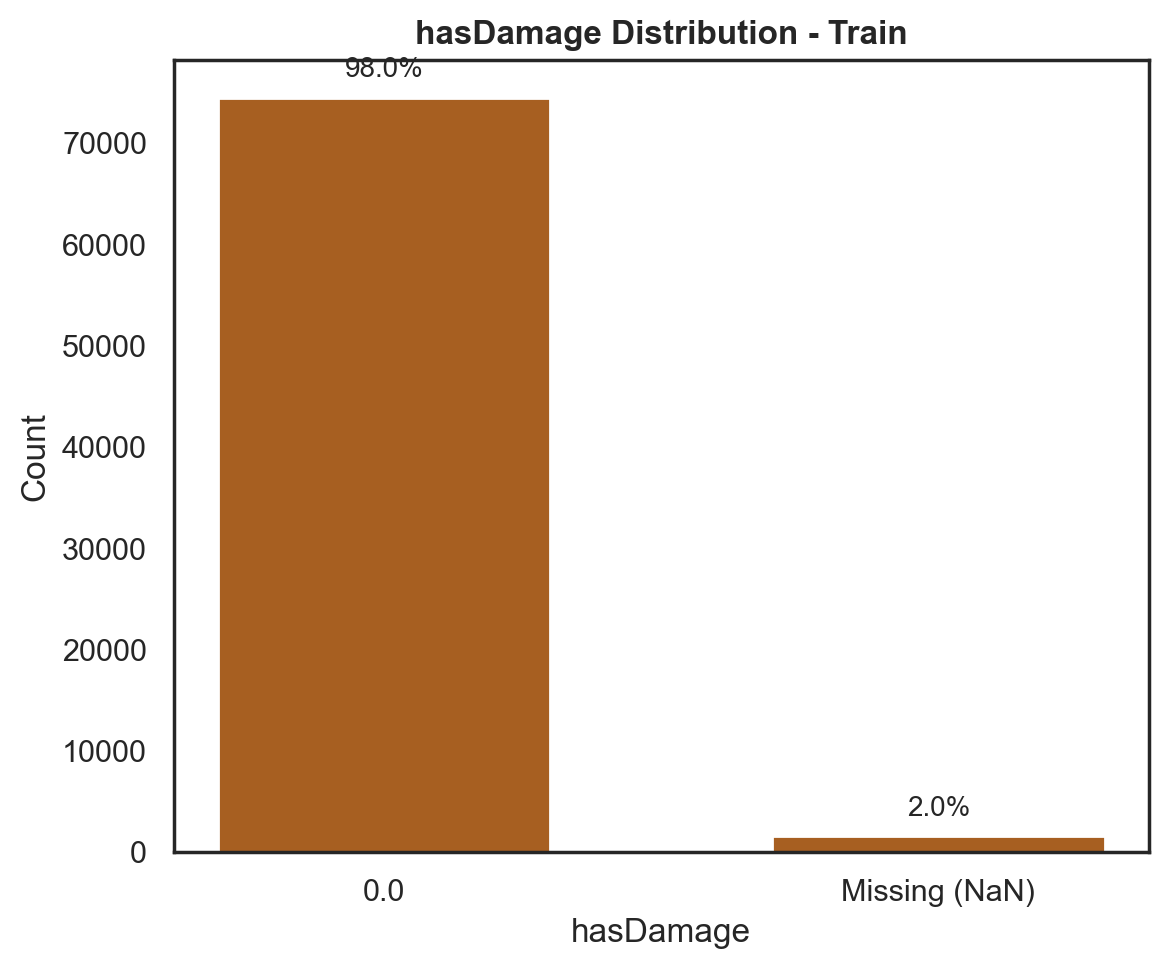

In [399]:
def plot_hasdamage_distribution(df, label='Train'):
    """Plot bar chart for hasDamage distribution."""
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Replace NaN with a label for visibility
    df_temp = df['hasDamage'].fillna('Missing (NaN)')
    counts = df_temp.value_counts()
    
    # Create bar plot
    ax.bar(range(len(counts)), counts.values, color='#a55b1bf9', width=0.6)
    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(counts.index)
    
    # Add percentage labels
    total = counts.sum()
    for i, v in enumerate(counts.values):
        ax.text(i, v + (counts.max() * 0.02), 
                f'{v/total*100:.1f}%', 
                ha='center', va='bottom', fontsize=10)
    
    ax.set_title(f'hasDamage Distribution - {label}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count')
    ax.set_xlabel('hasDamage')
    
    plt.tight_layout()
    plt.show()

# Plot hasDamage distribution for training data
plot_hasdamage_distribution(car_eval, 'Train')

The percentage of missing values is small and may correspond to vehicles with damage. However, it seems odd that the mechanic would forget to fill this in. It would make more sense if it were missing for vehicles without damage. Therefore, this variable still requires further evaluation to determine how to handle the missing values.

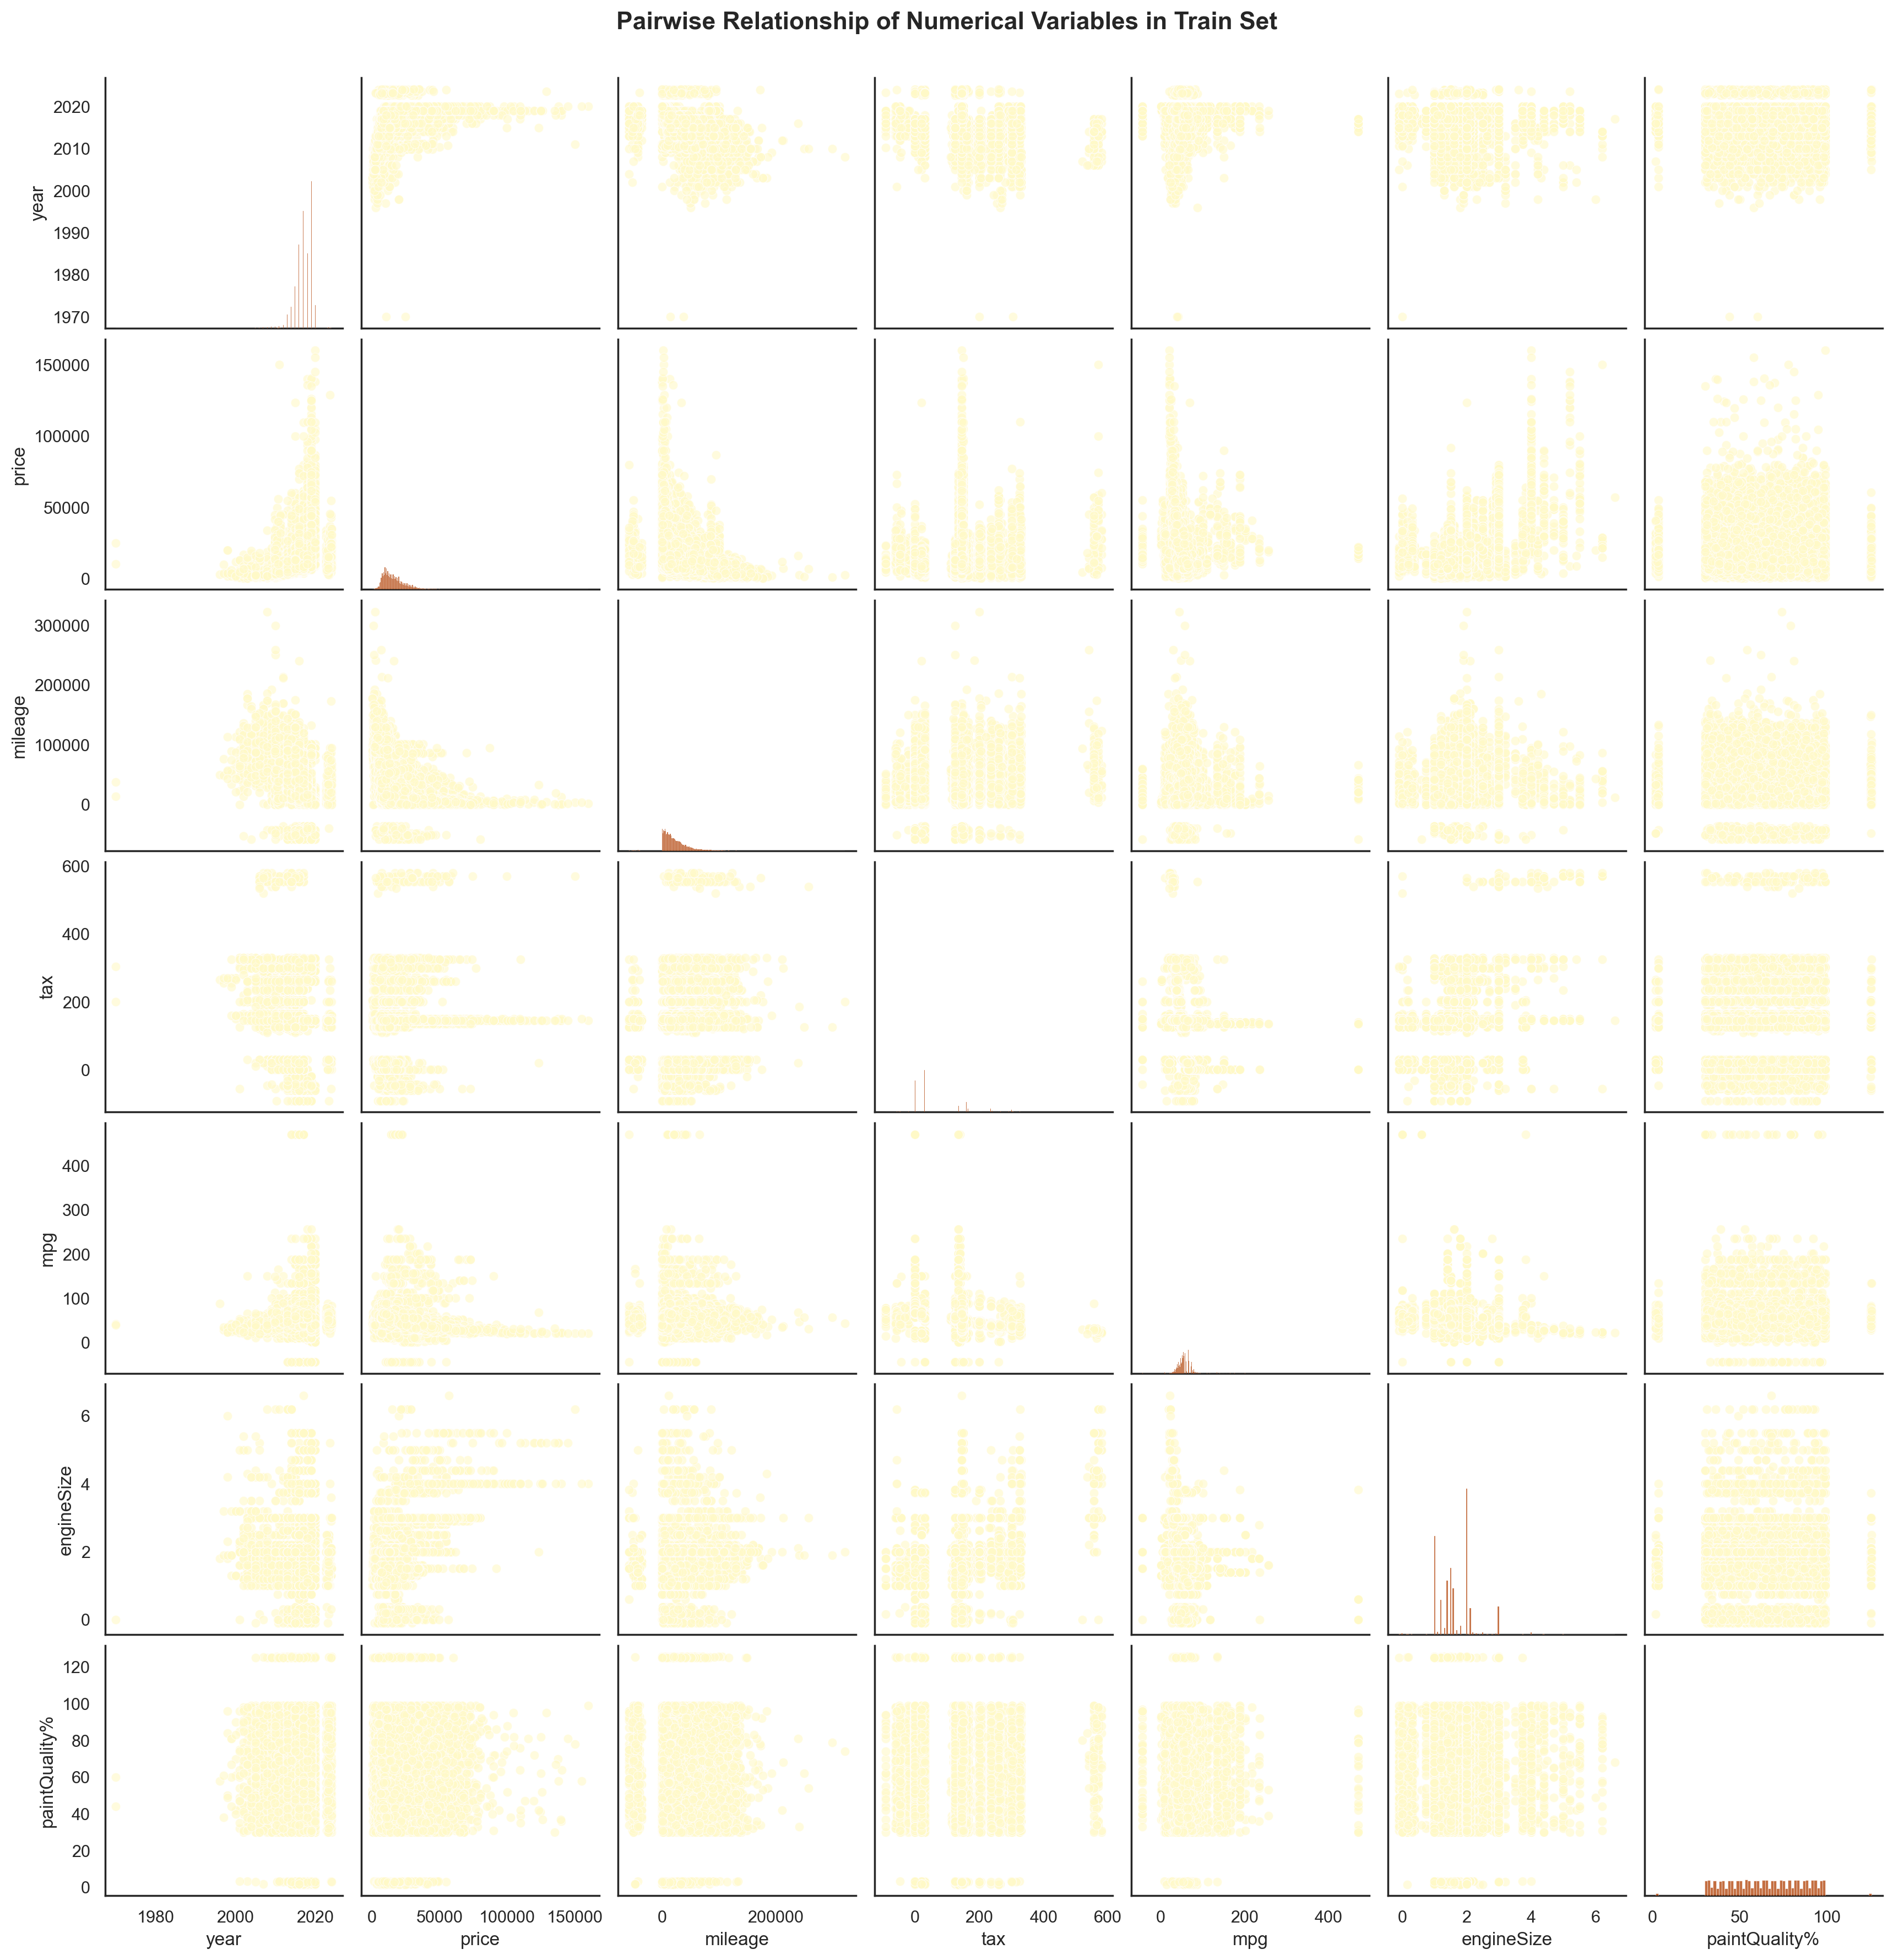

In [400]:
num_filtered = [col for col in num if col not in ['previousOwners', 'hasDamage']]

# Pairwise Relationship of Numerical Variables
sns.pairplot(
    car_eval[num_filtered],
    diag_kind='hist',
    plot_kws={'color': palette[0], 'alpha': 0.6},
    diag_kws={'color': palette[-2]}
)
plt.suptitle('Pairwise Relationship of Numerical Variables in Train Set', fontweight='bold', fontsize=16, y=1.02)
plt.show()

> We will postpone the multivariate analysis involving categorical variables until after addressing the existing inconsistencies. For now, we focus on pairwise relationships between numerical variables, excluding discrete integer variables with very few distinct values (`previousOwners` and `hasDamage`) since their scatter plots produce stacked points along horizontal or vertical lines, offering little meaningful insight.

Although no strong linear relationships are observed in the numerical features of the training set, several patterns and logical trends emerge:
- `Tax` and `paintQuality%` appear to have limited influence on the `price` (target), suggesting they may be less relevant features.

- It seems a bit strange that the distribution of `paintQuality%` jumps so abruptly from values near zero to around 30, since it is a continuous variable and fairly well distributed across the remaining range. And `paintQuality%` does not appear to be related to any of the other variables shown here.

- Cars with larger `engineSize` tend to have higher `price` which makes sense as larger engines are typically found in more powerful or luxury vehicles.

- Most expensive cars tend to have lower `mileage`. However, many low-mileage vehicles are priced within more common, mid-range levels. As `mileage` increases, the average `price` tends to decrease and its variability also becomes smaller.

- Most expensive cars are relatively recent and old cars tend to be cheaper. 

- For higher-priced cars, the `tax` values are clearly concentrated around a single point, which is quite below 200.

- Cars paying higher `tax` rates tend to have lower `mpg`, a common trait of high-performance or luxury cars.

- Older vehicles tend to have lower `mpg`, aligning with expectations about fuel efficiency over time.

- More expensive cars tend to have lower `mpg`, as they often feature larger, more powerful engines that consume more fuel.

- Once again, we can observe the presence of some luxury cars with low `mpg` and large `engineSizes`, but most vehicles have low `mpg` and small engines, corresponding to more standard models.

- Finally, the impossible negative values observed in some variables are likely the result of simple sign errors, as their distributions closely mirror those of their corresponding positive values.



### 3.4 Inconsistency Checks

In [401]:
MAX_UNIQUE_PRINT = 75

# Display unique values for all columns in car_eval
print("\033[1mUnique values for each column:\033[0m")
for col in car_eval.columns:
    unique_values = car_eval[col].unique()
    num_unique = len(unique_values)
    
    print(f"{col} ({num_unique} unique values):")
    
    if num_unique > MAX_UNIQUE_PRINT: #print only the first 75
        print(unique_values[:MAX_UNIQUE_PRINT])
        print(f"[ There are {num_unique - MAX_UNIQUE_PRINT} more unique values ... ]\n")
    else:
        print(unique_values)
        print("\n")

Unique values for each column:
Brand (73 unique values):
['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 'FOR'
 'mercedes' 'Hyundai' 'w' 'ord' 'MW' 'bmw' nan 'yundai' 'BM' 'Toyot' 'udi'
 'Ope' 'AUDI' 'V' 'opel' 'pel' 'For' 'pe' 'Mercede' 'audi' 'MERCEDES'
 'OPEL' 'koda' 'FORD' 'Hyunda' 'W' 'Aud' 'vw' 'hyundai' 'skoda' 'ford'
 'TOYOTA' 'ercedes' 'oyota' 'toyota' 'SKODA' 'Skod' 'HYUNDAI' 'kod' 'v'
 'for' 'SKOD' 'aud' 'KODA' 'PEL' 'yunda' 'or' 'UDI' 'OYOTA' 'HYUNDA' 'mw'
 'OPE' 'mercede' 'ERCEDES' 'ercede' 'TOYOT' 'MERCEDE' 'ORD' 'ud' 'ope'
 'AUD' 'hyunda' 'skod' 'toyot']


model (736 unique values):
[' Golf' ' Yaris' ' Q2' ' FIESTA' ' 2 Series' '3 Series' ' A3' ' Octavia'
 ' Passat' ' Focus' ' Insignia' ' A Clas' ' Q3' ' Fabia' ' A Class' ' Ka+'
 ' 3 Series' ' GLC Class' ' I30' ' C Class' ' Polo' ' E Class' ' C Clas'
 ' Q5' ' Up' ' Fiesta' ' C-HR' ' Mokka X' ' Corsa' ' Astra' ' TT'
 ' 5 Series' ' Aygo' ' 4 Series' ' SLK' ' Viva' ' T-Roc' 'Focus'
 ' EcoSport' ' Tucson' ' EcoS

We were already aware of many inconsistencies from the word cloud, but here we can get a clearer picture of them. In the next section, we will address the inconsistencies found and take the opportunity to create general consistency rules that can be applied.

### 3.5 Missing values

In [402]:
def missing_data(train_df, test_df=None):
    """Display missing data summary."""
    cols = train_df.columns if test_df is None else train_df.columns.intersection(test_df.columns)
    
    result = pd.DataFrame({
        'Train n': train_df[cols].isna().sum(),
        'Train %': (train_df[cols].isna().mean() * 100).round(2)
    })
    
    if test_df is not None:
        result['Test n'] = test_df[cols].isna().sum()
        result['Test %'] = (test_df[cols].isna().mean() * 100).round(2)
    
    return result[result['Train n'] > 0].sort_values('Train %', ascending=False)

missing_data(car_eval, X_test)

Train n  Train %  Test n  Test %
mpg                7924    10.43    3288   10.10
tax                7902    10.40    3308   10.16
hasDamage          1548     2.04     597    1.83
previousOwners     1550     2.04     597    1.83
paintQuality%      1524     2.01     625    1.92
transmission       1522     2.00     623    1.91
model              1517     2.00     650    2.00
Brand              1521     2.00     649    1.99
engineSize         1516     2.00     628    1.93
fuelType           1511     1.99     656    2.01
year               1491     1.96     653    2.01
mileage            1462     1.92     689    2.12

> We can observe a high percentage of missing values in `mpg` and `tax`, they are missing for 10.43% and 10.40% of the rows, respectively. This might indicate that these variables have limited predictive value. If used, they will require robust imputation since removing 10% of the data is not feasible. <br>
 The remaining variables show a small, consistent proportion of missing data (around 2%), which can be handled using standard imputation methods such as the median, mode, or algoritmic based imputation.

### 3.5 Train/Validation Split

Before proceeding with cleaning, we split the training data to ensure no data leakage.

In [403]:
# Split features and target
car_eval = car_eval.reset_index()

X = car_eval.drop(columns=['price'])
y = car_eval[['carID', 'price']]

# Train/validation split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=True,
    random_state=RANDOM_STATE
)

# Set carID as index
X_train, X_val = [d.set_index('carID') for d in (X_train, X_val)]
y_train, y_val = [d.set_index('carID') for d in (y_train, y_val)]

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

X_train: (60769, 12)
X_val: (15193, 12)
y_train: (60769, 1)
y_val: (15193, 1)


> A hold-out split of 80/20 was used, with `shuffle=True` to ensure a random and unbiased distribution of samples. <br>
It is essential to split the data into train and validation sets before performing steps such as missing value imputation or scaling, since the model should learn only from the training data. Otherwise, we would be introducing data leakage, which makes the model appear better than it actually is.      
 


In [404]:
# Drop rows with missing values above a threshold (40%)
threshold = 0.4

# % of missing values per row
missing_pct = X_train.isna().mean(axis=1)

# IDs of rows to drop
ids_to_drop = missing_pct[missing_pct >= threshold].index.tolist()

if ids_to_drop:
    print(f"Dropping {len(ids_to_drop)} rows from X_train and y_train (IDs: {ids_to_drop[:5]}{'...' if len(ids_to_drop) > 5 else ''})")
    X_train = X_train.drop(index=ids_to_drop)
    y_train = y_train.drop(index=ids_to_drop)
else:
    print("No rows to drop in X_train/y_train.")

Dropping 1 rows from X_train and y_train (IDs: [44389])


Following reasona and standard practice, we drop rows with 40%+ missing variables, since rows with such missingnes contributes little reliable information and consequent heavy imputation and could introduce excessive noise or bias.

<a id='4-cleaning'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>4 | Data Cleaning</b></span>
    </h1>
</div>

### 4.1 Brand & Model Standardization

The Brand and model columns contain inconsistencies (typos, variations). We use fuzzy matching against a reference dictionary from the wheel-size API.

In the first step, we normalize all brand and model fields using a  string standardization routine. This ensures that every comparison is made on a clean and consistent representation, avoiding mismatches caused by casing, spacing, or formatting noise.

In the second step, we apply a rule-based classifier (clean_brand_model_simple) to each row, assigning a bm_status and a short descriptive bm_note. This separates the clearly valid cases from the ambiguous ones, while keeping the logic transparent and traceable.

In the third and final step, we incorporate a set of structured manual fixes and handle the remaining uncertain rows explicitly. Ambiguous combinations are first forced to missing, and only then imputed using engine-size similarity (impute_model_by_engine_size).

In [405]:
brand_model_dic_norm = brand_model_dic.copy()

# Define allowed brands
ALLOWED_BRANDS = [
    "Volkswagen", "Toyota", "Audi", "Ford", "BMW", 
    "Skoda", "Opel", "Vauxhall", "Mercedes-Benz", "Hyundai"
]

# Filter to allowed brands only
brand_model_dic_norm = brand_model_dic_norm[
    brand_model_dic_norm["brand"].isin(ALLOWED_BRANDS)
].copy()

# Standardize brand names
brand_model_dic_norm["brand"] = brand_model_dic_norm["brand"].astype(str).str.replace(
    r"(?i)^mercedes[\s-]*benz$", "Mercedes", regex=True
)
brand_model_dic_norm['brand'] = brand_model_dic_norm['brand'].replace('Volkswagen', 'VW', regex=False)
brand_model_dic_norm['brand'] = brand_model_dic_norm['brand'].replace('Vauxhall', 'Opel', regex=False)

# Add manually identified models
extra_rows = [
    {'brand': 'VW', 'model': 'Shuttle'},
    {'brand': 'VW', 'model': 'Caddy Maxi Life'},
    {'brand': 'Skoda', 'model': 'yeti outdoor'}
]
brand_model_dic_norm = pd.concat([brand_model_dic_norm, pd.DataFrame(extra_rows)], ignore_index=True)

# Normalize using utils.norm
brand_model_dic_norm['Brand'] = brand_model_dic_norm['brand'].apply(utils.norm)
brand_model_dic_norm['model'] = brand_model_dic_norm['model'].apply(utils.norm)

# Fix specific model names
brand_model_dic_norm['model'] = brand_model_dic_norm['model'].replace('yeti', 'yeti outdoor', regex=False)
brand_model_dic_norm['model'] = brand_model_dic_norm['model'].replace('slk class', 'slk', regex=False)

# Remove duplicates
brand_model_dic_norm = brand_model_dic_norm.drop_duplicates(subset=['Brand', 'model'])

print(f"Reference dictionary: {len(brand_model_dic_norm)} brand-model combinations")
print(f"Unique brands: {brand_model_dic_norm['Brand'].nunique()}")

Reference dictionary: 985 brand-model combinations
Unique brands: 9


In [406]:
# Create lookup structures
valid_brands = sorted(brand_model_dic_norm['Brand'].dropna().unique())

models_by_brand = (
    brand_model_dic_norm
    .groupby('Brand')['model']
    .apply(list)
    .to_dict()
)

brands_by_model = (
    brand_model_dic_norm
    .groupby('model')['Brand']
    .apply(list)
    .to_dict()
)

# Models that appear in only one brand (can infer brand from model)
unique_brand_by_model = {
    m: brands[0]
    for m, brands in brands_by_model.items()
    if len(brands) == 1
}

# Manual corrections for known typos
MANUAL_MODEL_FIXES = {
    ('hyundai', 'i2'): 'i20',
    ('hyundai', 'ix2'): 'ix20',
}

print(f"Valid brands: {valid_brands}")
print(f"Models with unique brand: {len(unique_brand_by_model)}")

Valid brands: ['audi', 'bmw', 'ford', 'hyundai', 'mercedes', 'opel', 'skoda', 'toyota', 'vw']
Models with unique brand: 971


In [407]:
# Normalize Brand and model in all datasets
for df in [X_train, X_val, X_test]:
    df['Brand'] = df['Brand'].apply(utils.norm)
    df['model'] = df['model'].apply(utils.norm)

print("✅ Brand and model normalized in all datasets")

✅ Brand and model normalized in all datasets


In [408]:
def clean_brand_model_simple(df_to_clean):
    """
    Clean and standardize Brand and model columns using fuzzy matching.
    Tracks all corrections with bm_status and bm_note columns.
    """
    df = df_to_clean.copy()

    if 'Brand' not in df.columns or 'model' not in df.columns:
        raise ValueError("The DataFrame must contain 'Brand' and 'model' columns.")

    df['bm_status'] = 'ok'
    df['bm_note'] = ''

    all_models = brand_model_dic_norm['model'].tolist()

    def _fix_row(row):
        b = row['Brand']
        m = row['model']

        # Transform NaN to empty string
        b = '' if pd.isna(b) else str(b)
        m = '' if pd.isna(m) else str(m)

        # Case 0: Both empty
        if b == '' and m == '':
            row['bm_status'] = 'empty'
            return row

        # Case 1: Brand missing but model filled
        if b == '' and m != '':
            # Special rule: corsa → opel
            if m == 'corsa':
                row['Brand'] = 'opel'
                row['bm_status'] = 'brand_inferred'
                row['bm_note'] = "Brand set to 'opel' because model='corsa'"
                return row

            # If model is unique → infer brand
            if m in unique_brand_by_model:
                new_b = unique_brand_by_model[m]
                row['Brand'] = new_b
                row['bm_status'] = 'brand_inferred'
                row['bm_note'] = f"brand inferred from model '{m}'"
                return row

            # Fuzzy global match on model
            matches = utils.get_best_match(m, all_models)
            if len(matches) == 1:
                matched_model = matches[0]
                brands = brands_by_model.get(matched_model, [])
                if len(brands) == 1:
                    row['Brand'] = brands[0]
                    row['model'] = matched_model
                    row['bm_status'] = 'brand_inferred'
                    row['bm_note'] = f"brand inferred from fuzzy model match '{matched_model}'"
                else:
                    row['model'] = matched_model
                    row['bm_status'] = 'needs_review'
                    row['bm_note'] = f"model corrected to '{matched_model}', ambiguous brand"
            else:
                row['bm_status'] = 'needs_review'
                row['bm_note'] = "brand missing and model without clear match"
            return row

        # Case 2: Brand filled - validate or correct
        if b not in valid_brands:
            b_matches = utils.get_best_match(b, valid_brands)
            if len(b_matches) == 1:
                new_b = b_matches[0]
                row['Brand'] = new_b
                row['bm_status'] = 'brand_corrected'
                row['bm_note'] = f"brand corrected from '{b}' to '{new_b}'"
                b = new_b
            else:
                row['bm_status'] = 'needs_review'
                row['bm_note'] = f"invalid brand: '{b}'"
                return row

        # Manual model corrections
        key = (b, m)
        if key in MANUAL_MODEL_FIXES:
            new_m = MANUAL_MODEL_FIXES[key]
            row['model'] = new_m
            row['bm_status'] = 'model_corrected'
            row['bm_note'] = f"model manually corrected from '{m}' to '{new_m}'"
            m = new_m

        # Case 3: Model missing
        if m == '':
            row['bm_status'] = 'no_model'
            row['bm_note'] = "model missing"
            return row

        # Case 3a: Exact match within brand
        brand_models = models_by_brand.get(b, [])
        if m in brand_models:
            return row  # Perfect match

        # Case 3b: Fuzzy match within brand
        if brand_models:
            m_matches = utils.get_best_match(m, brand_models)
            if len(m_matches) == 1:
                new_m = m_matches[0]
                row['model'] = new_m
                row['bm_status'] = 'model_corrected'
                row['bm_note'] = f"model corrected from '{m}' to '{new_m}' within brand '{b}'"
                return row

        # Case 3c: Global fuzzy match (may change brand)
        m_matches_global = utils.get_best_match(m, all_models)
        if len(m_matches_global) == 1:
            new_m = m_matches_global[0]
            brands_for_m = brands_by_model.get(new_m, [])
            if len(brands_for_m) == 1 and brands_for_m[0] != b:
                new_b = brands_for_m[0]
                row['Brand'] = new_b
                row['model'] = new_m
                row['bm_status'] = 'brand_from_model'
                row['bm_note'] = f"brand changed from '{b}' to '{new_b}' because of model '{new_m}'"
            else:
                row['model'] = new_m
                row['bm_status'] = 'model_corrected'
                row['bm_note'] = f"model corrected globally from '{m}' to '{new_m}'"
            return row

        # Case 3d: No match found
        row['bm_status'] = 'needs_review'
        row['bm_note'] = f"combination Brand='{b}', model='{m}' has no acceptable fuzzy match"
        return row

    df = df.apply(_fix_row, axis=1)
    return df

In [409]:
# Apply cleaning to ALL datasets
print("Cleaning X_train...")
X_train_clean = clean_brand_model_simple(X_train)

print("Cleaning X_val...")
X_val_clean = clean_brand_model_simple(X_val)

print("Cleaning X_test...")
X_test_clean = clean_brand_model_simple(X_test)

# Show status distribution for training set
print("\n=== X_train Status Distribution ===")
print(X_train_clean['bm_status'].value_counts())

Cleaning X_train...
Cleaning X_val...
Cleaning X_test...

=== X_train Status Distribution ===
bm_status
ok                  54747
brand_corrected      2300
no_model             1206
brand_inferred       1184
model_corrected      1086
needs_review          155
brand_from_model       66
empty                  24
Name: count, dtype: int64


In [410]:
# Show rows that need review
print("\n=== Rows needing review (X_train) ===")
needs_review = X_train_clean[X_train_clean['bm_status'] == 'needs_review'][['Brand', 'model', 'bm_note']]
print(f"Total: {len(needs_review)} rows")
display(needs_review.head(20))


=== Rows needing review (X_train) ===
Total: 155 rows


Brand   model                                            bm_note
carID                                                                 
7816    bmw       m  combination Brand='bmw', model='m' has no acce...
2047   audi       a  combination Brand='audi', model='a' has no acc...
5424   audi       a  combination Brand='audi', model='a' has no acc...
1591   audi       q  combination Brand='audi', model='q' has no acc...
4415   audi       a  combination Brand='audi', model='a' has no acc...
510    audi       q  combination Brand='audi', model='q' has no acc...
6050   audi       a  combination Brand='audi', model='a' has no acc...
12253   bmw       x  combination Brand='bmw', model='x' has no acce...
4995   audi       q  combination Brand='audi', model='q' has no acc...
3164   audi       a  combination Brand='audi', model='a' has no acc...
12679   bmw       x  combination Brand='bmw', model='x' has no acce...
6500   audi       q  combination Brand='audi', model='q' has no acc...
14098  None       x        brand missing and model without clear match
1947   audi       a  combination Brand='audi', model='a' has no acc...
8001    bmw       x  combination Brand='bmw', model='x' has no acce...
60724  opel  kadjar  combination Brand='opel', model='kadjar' has n...
9990    bmw       x  combination Brand='bmw', model='x' has no acce...
6943   audi       a  combination Brand='audi', model='a' has no acc...
4351   audi       q  combination Brand='audi', model='q' has no acc...
2723   audi       a  combination Brand='audi', model='a' has no acc...

#### _Impute Model by Engine Size_

In this step, we focus on the rows where the model information is still uncertain after the initial cleaning. We use the engine size and the brand to find similar cars in the reference data and select the most frequent model among the nearest neighbours. This approach allows us to fill in missing or ambiguous models in a structured way, while keeping track of the imputation through the `bm_status` and `bm_note` columns.


In [411]:
K_NEIGHBORS = 5

def impute_model_by_engine_size(df_in, reference_df=None):
    """
    Impute model for 'needs_review' rows using KNN on engineSize.
    Uses reference_df for finding neighbors (to prevent data leakage).
    """
    df = df_in.copy()
    
    # Use self as reference if not provided
    if reference_df is None:
        reference_df = df
    
    mask_needs_review = df['bm_status'] == 'needs_review'
    df_needs_review = df[mask_needs_review]
    df_reference = reference_df[reference_df['bm_status'] != 'needs_review'].copy()
    
    corrected_models = {}

    for car_id, row in df_needs_review.iterrows():
        current_brand = row['Brand']
        current_model = row['model']
        current_engine_size = row['engineSize']
        
        if pd.isna(current_brand) or pd.isna(current_engine_size):
            continue

        # Filter references by same Brand
        ref_by_brand = df_reference[df_reference['Brand'] == current_brand].copy()

        # For short models (≤2 chars), match by prefix
        if len(str(current_model)) <= 2:
            ref_by_brand = ref_by_brand[
                ref_by_brand['model'].str.startswith(str(current_model), na=False)
            ]
        
        ref_by_brand = ref_by_brand.dropna(subset=['engineSize'])
        if ref_by_brand.empty:
            continue

        # Find K nearest neighbors by engineSize
        distance = np.abs(ref_by_brand['engineSize'] - current_engine_size)
        nearest_neighbors = distance.nsmallest(K_NEIGHBORS).index
        
        # Use mode of neighbors' models
        inferred_model = ref_by_brand.loc[nearest_neighbors, 'model'].mode().iloc[0]
        corrected_models[car_id] = inferred_model

    # Update DataFrame
    for car_id, new_model in corrected_models.items():
        df.loc[car_id, 'model'] = new_model
        df.loc[car_id, 'bm_status'] = 'model_imputed_by_esize'
        df.loc[car_id, 'bm_note'] = f"Model imputed to '{new_model}' using engineSize/prefix similarity."
        
    return df

In [412]:
# Apply imputation - use X_train_clean as reference for all datasets
X_train_clean = impute_model_by_engine_size(X_train_clean, reference_df=X_train_clean)
X_val_clean = impute_model_by_engine_size(X_val_clean, reference_df=X_train_clean)
X_test_clean = impute_model_by_engine_size(X_test_clean, reference_df=X_train_clean)

print("X_train status:", X_train_clean['bm_status'].value_counts().to_dict())
print("X_val status:", X_val_clean['bm_status'].value_counts().to_dict())
print("X_test status:", X_test_clean['bm_status'].value_counts().to_dict())

X_train status: {'ok': 54747, 'brand_corrected': 2300, 'no_model': 1206, 'brand_inferred': 1184, 'model_corrected': 1086, 'model_imputed_by_esize': 149, 'brand_from_model': 66, 'empty': 24, 'needs_review': 6}
X_val status: {'ok': 13780, 'brand_corrected': 511, 'brand_inferred': 296, 'no_model': 274, 'model_corrected': 266, 'model_imputed_by_esize': 34, 'brand_from_model': 20, 'empty': 12}
X_test status: {'ok': 29400, 'brand_corrected': 1215, 'no_model': 634, 'brand_inferred': 630, 'model_corrected': 560, 'model_imputed_by_esize': 60, 'brand_from_model': 47, 'empty': 16, 'needs_review': 5}


#### _Handle Remaining Unresolved Cases_

Here, we handle the rows that remain unresolved even after the imputation step. For these cases, we explicitly set the model to missing and update the status and note fields to reflect that the value is intentionally unknown. This ensures that no ambiguous model labels are silently propagated into the final dataset.


In [413]:
def force_missing_model(df_in):
    """Set model to None for remaining unresolved cases."""
    df = df_in.copy()
    mask = df['bm_status'] == 'needs_review'
    
    df.loc[mask, 'model'] = None
    df.loc[mask, 'bm_status'] = 'forced_missing'
    df.loc[mask, 'bm_note'] = "model set to missing due to unresolved review status."
    
    return df

# Apply to all datasets
X_train_clean = force_missing_model(X_train_clean)
X_val_clean = force_missing_model(X_val_clean)
X_test_clean = force_missing_model(X_test_clean)

# Verify no more needs_review
print("Remaining 'needs_review' cases:")
print(f"  X_train: {(X_train_clean['bm_status'] == 'needs_review').sum()}")
print(f"  X_val: {(X_val_clean['bm_status'] == 'needs_review').sum()}")
print(f"  X_test: {(X_test_clean['bm_status'] == 'needs_review').sum()}")

Remaining 'needs_review' cases:
  X_train: 0
  X_val: 0
  X_test: 0


In [414]:
# Drop status columns and update main dataframes
X_train_clean.drop(columns=['bm_status', 'bm_note'], inplace=True)
X_val_clean.drop(columns=['bm_status', 'bm_note'], inplace=True)
X_test_clean.drop(columns=['bm_status', 'bm_note'], inplace=True)

# Replace original dataframes
X_train = X_train_clean.copy()
X_val = X_val_clean.copy()
X_test = X_test_clean.copy()

print("✅ Brand/Model cleaning complete for all datasets")

✅ Brand/Model cleaning complete for all datasets


#### _Handle Unseen Models in Val/Test_

Here we align the validation and test sets with the training space by checking for models that do not appear in the training data. Any such unseen models are grouped under a generic 'other' category, which prevents issues during encoding and keeps the model focused on patterns it has actually observed during training.


In [415]:
# Check for models in val/test not seen in training
train_models = set(X_train['model'].dropna().unique())

for df, name in [(X_val, 'Validation'), (X_test, 'Test')]:
    df_models = set(df['model'].dropna().unique())
    unseen = df_models - train_models
    if unseen:
        print(f"Unseen models in {name}: {len(unseen)}")
        df.loc[df['model'].isin(unseen), 'model'] = 'other'

print(f"\nUnique brands in training: {X_train['Brand'].nunique()}")
print(f"Unique models in training: {X_train['model'].nunique()}")

Unseen models in Validation: 4
Unseen models in Test: 8

Unique brands in training: 9
Unique models in training: 182


### 4.2 Numeric Variables Cleaning

The illogical data issues identify such as negative values, out-of-bounds values, and zeros that incorrectly appear are adressed as follows:

We begin by converting each variable to its absolute value, which removes negative signs that do not have semantic meaning for attributes like mileage, tax, MPG, and ownership count. For the `year` field, we also cap unrealistic values above 2020 to prevent extreme outliers from influencing the models.Next, we treat zeros in the `engineSize` column as missing and convert them to `NaN`, since an engine size of zero is not physically meaningful. We then clip the `paintQuality%` field to the valid range of 0 to 100 and coerce invalid entries into numeric form.

In [416]:
# Clean numeric variables
for df in [X_train, X_val, X_test]:
    # Year: take absolute value, cap at 2020
    df['year'] = df['year'].apply(lambda x: abs(int(x)) if pd.notnull(x) else x)
    df.loc[df['year'] > 2020, 'year'] = 2020
    
    # Mileage: take absolute value
    df['mileage'] = df['mileage'].apply(lambda x: abs(float(x)) if pd.notnull(x) else np.nan)
    
    # Tax: take absolute value
    df['tax'] = df['tax'].apply(lambda x: abs(float(x)) if pd.notnull(x) else np.nan)
    
    # MPG: take absolute value
    df['mpg'] = df['mpg'].apply(lambda x: abs(float(x)) if pd.notnull(x) else np.nan)
    
    # Engine Size: 0 values are missing
    df.loc[df['engineSize'] == 0, 'engineSize'] = np.nan
    df['engineSize'] = df['engineSize'].apply(lambda x: abs(float(x)) if pd.notnull(x) else np.nan)
    
    # Paint Quality: clip to [0, 100]
    df['paintQuality%'] = pd.to_numeric(df['paintQuality%'], errors='coerce').clip(0, 100)
    
    # Previous Owners: take absolute value
    df['previousOwners'] = df['previousOwners'].apply(lambda x: abs(int(x)) if pd.notnull(x) else np.nan)

print("✅ Numeric variables cleaned")

✅ Numeric variables cleaned


### 4.3 Categorical Variables Cleaning

In this step, we clean and standardize the main categorical variables related to the vehicle's transmission and fuel type. We start by defining a small set of valid, normalized labels that represent the categories we expect to see in the data.

We then use a fuzzy-matching helper to correct misspellings and inconsistent entries, mapping them to the closest valid label whenever there is a clear match. If the algorithm finds multiple plausible matches or no sufficiently good match, we fall back to a generic category instead of guessing. This ensures that the transmission and fuel type fields are consistent.

In [ ]:
def correct_categorical_value(input_value, valid_values, min_score=0.6, fallback='unknown'):
    """Correct categorical value using fuzzy matching."""
    normalized = utils.norm(input_value)
    matches = utils.get_best_match(normalized, valid_values, min_score=min_score)
    
    if isinstance(matches, list) and len(matches) == 1:
        return matches[0]
    elif isinstance(matches, list) and len(matches) > 1:
        return None 
    return fallback

# Define valid values
transmission_valid = [utils.norm(x) for x in ['Manual', 'Automatic', 'Semi-Auto', 'Other']]
fueltype_valid = [utils.norm(x) for x in ['Petrol', 'Diesel', 'Hybrid', 'Electric', 'Other']]

# Apply corrections
for df in [X_train, X_val, X_test]:
    df['transmission'] = df['transmission'].apply(lambda x: correct_categorical_value(x, transmission_valid))
    df['fuelType'] = df['fuelType'].apply(lambda x: correct_categorical_value(x, fueltype_valid))

print("Transmission values:", X_train['transmission'].unique())
print("Fuel type values:", X_train['fuelType'].unique())

Transmission values: ['manual' 'semi auto' 'automatic' 'unknown' 'other']
Fuel type values: ['diesel' 'petrol' 'hybrid' 'unknown' 'other' 'electric']


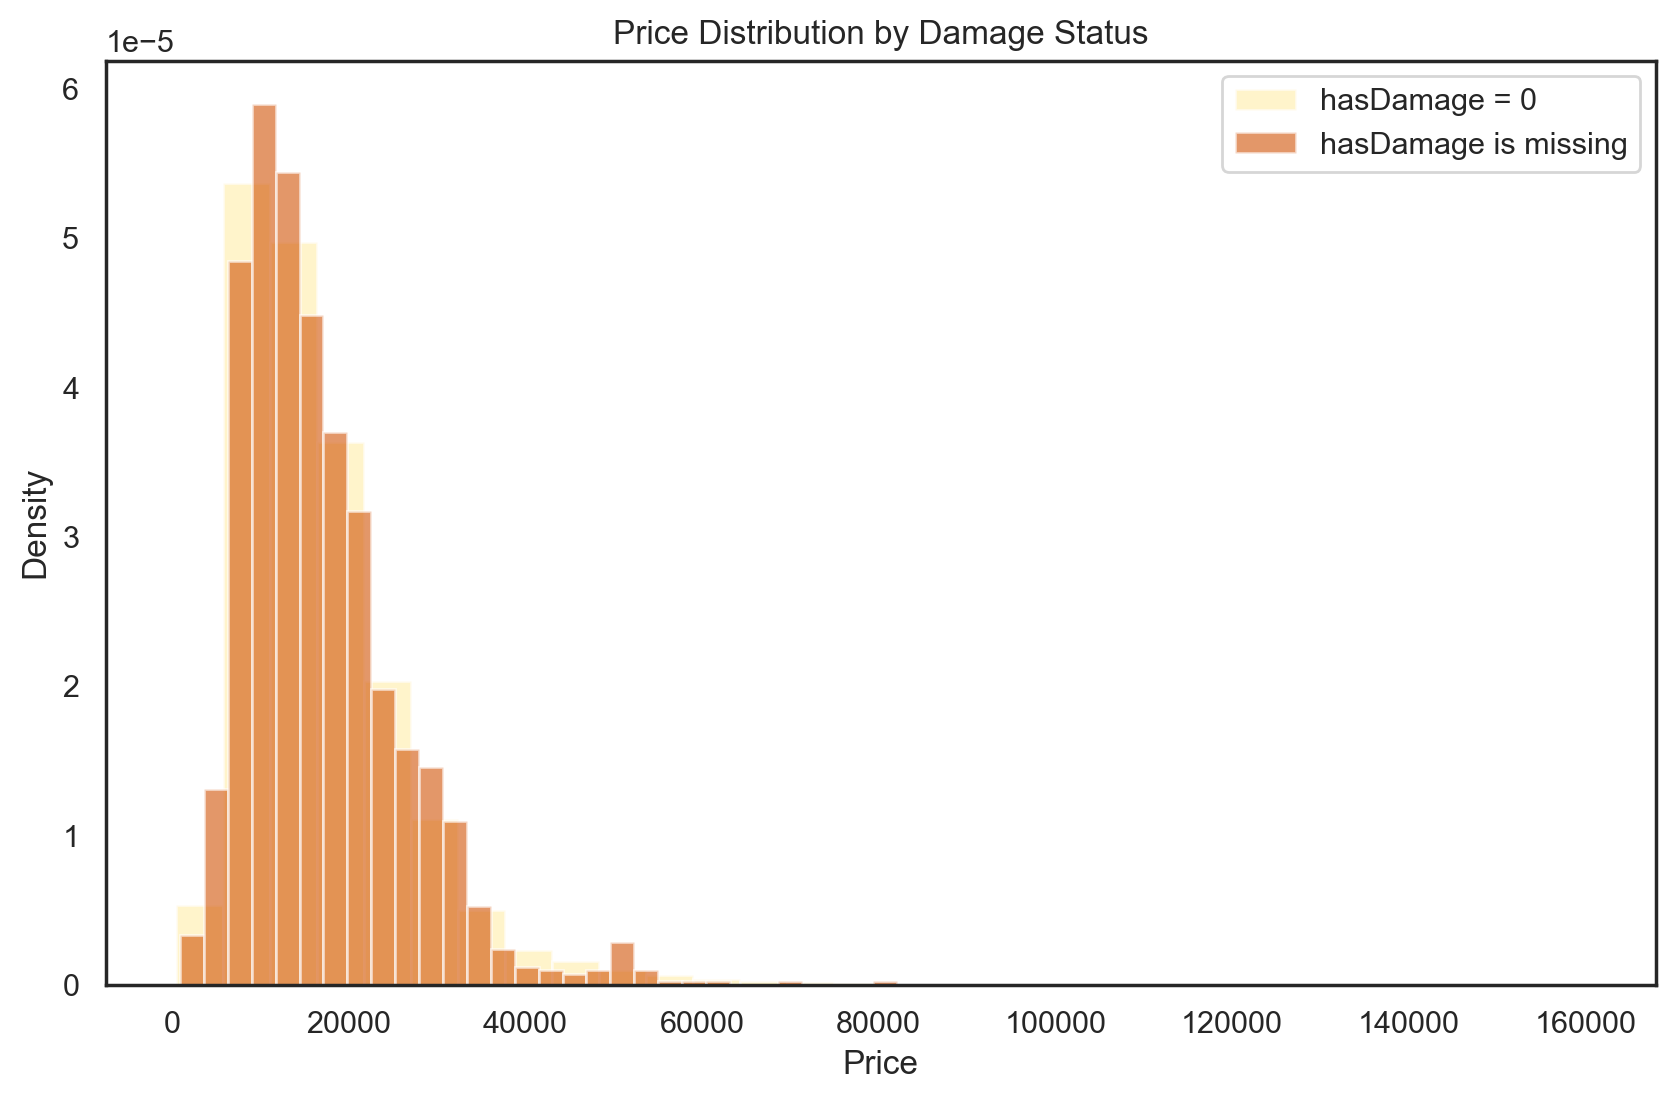

In [418]:
price_hasdamage_0 = car_eval.loc[car_eval['hasDamage'] ==0, 'price']
price_hasdamage_na = car_eval.loc[car_eval['hasDamage'].isna(), 'price']

plt.figure(figsize=(10,6))
plt.hist(price_hasdamage_0, bins=30, alpha=0.6, label='hasDamage = 0', color=palette[1], density=True)
plt.hist(price_hasdamage_na, bins=30, alpha=0.6, label='hasDamage is missing', color=palette[-3], density=True)

plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Price Distribution by Damage Status')
plt.legend()
plt.show()

Contrary to what one might expect, the price distribution when `hasDamage = 0` is similar to the distribution when `hasDamage` is missing, which suggests that, regardless of whether the missing values actually correspond to `hasDamage = 1` or not, this variable does not seem to have a significant impact on price. Therefore, we will leave the variable as it is for now, although it is likely to be excluded during feature selection or even earlier.

After adressing the inconsistencies, possible duplicate rows are removed. 

In [419]:
# Remove duplicates after cleaning
before = len(X_train)
X_train = X_train.drop_duplicates(keep='last')
y_train = y_train.loc[X_train.index]
print(f"Removed {before - len(X_train)} duplicates from training set")

# Fill remaining NaN in Brand/model with 'unknown'
for df in [X_train, X_val, X_test]:
    df['Brand'] = df['Brand'].fillna('unknown').replace('None', 'unknown')
    df['model'] = df['model'].fillna('unknown').replace('None', 'unknown')

Removed 5 duplicates from training set


<a id='5-missing'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>5 | Missing Data Treatment</b></span>
    </h1>
</div>

We decided to **keep all “unknown” categories** and assign the label _'unknown'_ to any remaining missing values in categorical variables.

Using only traditional methods for handling missing data such as deleting rows (listwise deletion) or filling with the mean (mean imputation) can be risky, and is often sub-optimal. They can introduce bias, reduce statistical power, and lead to misleading conclusions (Alruhaymi & Kim, 2021).

The best methods to be used in the handling of missing data are direclty dependent the classification of the type of such data (or absence thereof). Namely, they are dependent on the *reason* for their absence (or type of absence) (Rubin, 1976)

For numerical variables, we perform imputation using either **MICE Imputation** or the **median/mean**, depending on the nature of the missingness: when variables are **Missing At Random (MAR)**, we use the KNN Imputer to leverage correlations among features; when they are **Missing Completely At Random (MCAR)**, we use the median or mean as a simpler, more appropriate strategy.

### 5.1 MAR/MCAR Analysis

**Theory**

The plausibility of the Missing at Random (MAR) assumption can be assessed by checking whether missingness in one variable is systematically related to observed values in other variables, often tested by using  t-tests for continuous predictors and chi-square tests for categorical predictor. 

Following this logic, we create a **dummy variable** for missingness(1 = missing, 0 = present) and then use **t-tests** (for numeric variables) and **chi-squared tests** (for categorical variables) to check whether missingness is related with other variables.

These tests were stored within the created function `test_missingness_Xtrain`.

The logic is as follows: Simple imputation is deemed suitable for when the data are Missing Completely at Random (MCAR), in other words where missingness occurs purely by chance. If the data are Missing at Random (MAR), meaning missingness depends on other observed variables, multivariate Imputation is superior, since it leverages those existing relationships to fill in missing values, and is therefore more accurate (Tiwaskar & Thite, 2025).

In [420]:
def test_missingness(df, target, num_cols):
    """
    Test if missingness in target column is related to other variables.
    Uses t-tests for numeric and chi-square for categorical predictors.
    """
    df = df.copy()
    miss_col = target + '_missing'
    df[miss_col] = df[target].isna().astype(int)
    
    results = []
    
    # Numeric predictors: t-tests
    for col in num_cols:
        if col != target and col in df.columns:
            group0 = df.loc[df[miss_col] == 0, col].dropna()
            group1 = df.loc[df[miss_col] == 1, col].dropna()
            if len(group0) > 1 and len(group1) > 1:
                _, p = ttest_ind(group0, group1, equal_var=False)
                results.append((target, col, 't-test', p))
    
    # Categorical predictors: chi-square
    cat_cols = df.select_dtypes(exclude='number').columns
    for col in cat_cols:
        if col != miss_col:
            table = pd.crosstab(df[col], df[miss_col])
            if table.shape[0] > 1:
                _, p, _, _ = chi2_contingency(table)
                results.append((target, col, 'chi-square', p))
    
    return pd.DataFrame(results, columns=['Target', 'Variable', 'Test', 'p_value'])

In [421]:
# Join with price for analysis
X_train_with_price = X_train.join(y_train)

# Identify variables with missing values
vars_with_missing = [col for col in X_train.columns if X_train[col].isna().sum() > 0]
num_cols = X_train_with_price.select_dtypes('number').columns

# Test each variable
all_results = []
for var in vars_with_missing:
    results = test_missingness(X_train_with_price, var, num_cols)
    sig_vars = results[results['p_value'] < 0.05]['Variable'].tolist()
    status = "MAR" if len(sig_vars) > 0 else "MCAR"
    all_results.append({
        'Variable': var,
        'Missing_n': X_train[var].isna().sum(),
        'Missing_%': round(X_train[var].isna().mean() * 100, 2),
        'Status': status,
        'Related_to': ', '.join(sig_vars[:5]) + ('...' if len(sig_vars) > 5 else '') if sig_vars else '—'
    })

summary = pd.DataFrame(all_results).sort_values('Missing_%', ascending=False)
summary

Variable  Missing_n  Missing_% Status  \
3             mpg       6344      10.44    MAR   
2             tax       6307      10.38    MAR   
4      engineSize       1351       2.22    MAR   
7       hasDamage       1264       2.08   MCAR   
6  previousOwners       1258       2.07   MCAR   
5   paintQuality%       1230       2.02   MCAR   
0            year       1220       2.01    MAR   
1         mileage       1150       1.89   MCAR   

                                 Related_to  
3  year, engineSize, price, Brand, model...  
2    year, mpg, engineSize, price, Brand...  
4                  mpg, model, transmission  
7                                         —  
6                                         —  
5                                         —  
0                                  fuelType  
1                                         —

**Note:** We acknowledge a limitation in our approach: running multiple tests as we did increases the probability of a Type I error.

### 5.2 Imputation Strategy


**MCAR Variables:  `hasDamage`, `paintQuality%`, `previousOwners` and `mileage`:** 

Our tests found no statistical relationship between their missingness and any other variable in the dataset.

**Action:**  
As per our defined logic, since the data are MCAR, we can safely use simple imputation methods.  We fill all variables (since they are numerical) with their **median** or **mean**. As mentioned, this approach is consistent, efficient, and appropriate when the missingness is completely random.


**MAR Variables: `mpg`, `tax`, `engineSize` and `year`:**

The results indicate a **MAR** pattern — each of these variables has at least one “significant variable,” showing that their missingness is not random.


**Action:**  
As per the defined logic above, since these variables are MAR, we use multivariate imputation, via `MICE`.


#### _MCAR Imputation (Simple)_

In [422]:
# MCAR variables: simple imputation
paint_mean = X_train['paintQuality%'].mean()
owners_median = X_train['previousOwners'].median()
mileage_median = X_train['mileage'].median()
damage_median = X_train['hasDamage'].median()

for df in [X_train, X_val, X_test]:
    df['paintQuality%'] = pd.to_numeric(df['paintQuality%'], errors='coerce').fillna(paint_mean)
    df['previousOwners'] = pd.to_numeric(df['previousOwners'], errors='coerce').fillna(owners_median)
    df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce').fillna(mileage_median)
    df['hasDamage'] = pd.to_numeric(df['hasDamage'], errors='coerce').fillna(damage_median)

print("✅ MCAR variables imputed")

✅ MCAR variables imputed


In [423]:
# mode for Brand and model
brand_mode = X_train['Brand'].mode()[0]
model_mode_per_brand = (
    X_train.groupby('Brand')['model']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown')
    .to_dict()
)
print(f"Mode of Brand: {brand_mode}")
print("Mode of model by Brand:")
for brand, mode in model_mode_per_brand.items():
    print(f"  {brand}: {mode}")

Mode of Brand: ford
Mode of model by Brand:
  audi: a3
  bmw: 3 series
  ford: focus
  hyundai: tucson
  mercedes: c class
  opel: corsa
  skoda: fabia
  toyota: yaris
  unknown: unknown
  vw: golf


In [424]:
# For categorical MCAR variables (Brand and model): use mode to fill missing values
X_train['Brand'] = X_train['Brand'].fillna(brand_mode)
missing_mask = X_train['model'].isna()
X_train.loc[missing_mask, 'model'] = X_train.loc[missing_mask, 'Brand'].map(model_mode_per_brand)

#### _MAR Imputation (MICE)_

In [425]:
# Create missing flags for MAR variables before imputation
mar_vars = ['mpg', 'tax', 'engineSize', 'year']

for var in mar_vars:
    flag_col = f"{var}_is_missing"
    for df in [X_train, X_val, X_test]:
        df[flag_col] = df[var].isna().astype(int)

print(f"Created missing flags for: {mar_vars}")

Created missing flags for: ['mpg', 'tax', 'engineSize', 'year']


In [ ]:
# MICE imputation for MAR variables
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

mice_imputer = IterativeImputer(max_iter=10, random_state=RANDOM_STATE)
scaler = RobustScaler()

# Fit on training data
train_numeric = X_train[numeric_cols].copy()
train_imputed = mice_imputer.fit_transform(train_numeric)
train_scaled = scaler.fit_transform(train_imputed)

X_train[numeric_cols] = pd.DataFrame(train_scaled, index=X_train.index, columns=numeric_cols)

# Transform validation and test
for df in [X_val, X_test]:
    df_numeric = df[numeric_cols].copy()
    df_imputed = mice_imputer.transform(df_numeric)
    df_scaled = scaler.transform(df_imputed)
    df[numeric_cols] = pd.DataFrame(df_scaled, index=df.index, columns=numeric_cols)
    

print("✅ MICE imputation and RobustScaler applied to all datasets")

✅ MICE imputation and RobustScaler applied to all datasets


In [427]:
missing_data(X_train)

Empty DataFrame
Columns: [Train n, Train %]
Index: []

Now that we have imputed additional values, it is possible that more duplicates have appeared (but it is not the case here)

In [428]:
#Check for duplicates in the training sets
utils.print_dup_info(X_train, name="X_train")

Total duplicates in X_train: 0


In [429]:
# Get the shape of the datasets
print("X_train shape after removing duplicates:", X_train.shape)
print("y_train shape after removing duplicates:", y_train.shape)

X_train shape after removing duplicates: (60763, 16)
y_train shape after removing duplicates: (60763, 1)


<a id='6-outliers'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>6 | Outlier Detection</b></span>
    </h1>
</div>

The initial Exploratory Data Analysis revealed the presence of several outliers. Outliers identified as data errors have already been addressed during the data cleaning and consistency checks. In this section, the focus shifts to the remaining **Valid Outliers** to determine the appropriate handling strategy.

In [430]:
def compare_outlier_detection(df, columns, iqr_factor=1.5, mad_threshold=3.5, return_indices=False):

    # Just to ensure columns is a list
    if isinstance(columns, str):
        columns = [columns]
    
    results_list = []
    all_indices = {'iqr': set(), 'mad': set(), 'both': set()}

    # Iterate through each column
    for column in columns:
        if column not in df.columns:
            print(f"Column '{column}' not found in the DataFrame. Skipping.")
            continue
        
        data_series = df[column]

        ### IQR Method Calculations ###
        Q1 = data_series.quantile(0.25)
        Q3 = data_series.quantile(0.75)
        IQR = Q3-Q1
        iqr_lower_bound = Q1- (iqr_factor * IQR)
        iqr_upper_bound = Q3+ (iqr_factor * IQR)
        iqr_outliers_filter = (data_series < iqr_lower_bound) | (data_series > iqr_upper_bound)
        iqr_outlier_indices = set(df[iqr_outliers_filter].index)
        
        ### MAD Method Calculations ###
        median = data_series.median()
        mad = (data_series - median).abs().median()
        
        # Handle case where MAD is zero
        if mad == 0:
            mad_lower_bound = median
            mad_upper_bound = median
            # If MAD is zero, consider all values as outliers that are not equal to the median
            mad_outliers_filter = (data_series != median)
        else:
            mad_lower_bound = median - (mad_threshold * mad)
            mad_upper_bound = median + (mad_threshold * mad)
            mad_outliers_filter = (data_series < mad_lower_bound) | (data_series > mad_upper_bound)
        
        mad_outlier_indices = set(df[mad_outliers_filter].index)

        # Comparison Calculations
        both_indices = iqr_outlier_indices.intersection(mad_outlier_indices)
        
        column_summary = {
            'Column': column,
            'Outlier Count (IQR)': len(iqr_outlier_indices),
            'Outlier % (IQR)': round(len(iqr_outlier_indices) / len(df) * 100, 2),
            'Outlier Count (MAD)': len(mad_outlier_indices),
            'Outlier % (MAD)': round(len(mad_outlier_indices) / len(df) * 100, 2),
            'Outlier Count (Both)': len(both_indices),
            'Outlier % (Both)': round(len(both_indices) / len(df) * 100, 2),
        }
        results_list.append(column_summary)

        # Store indices if requested
        if return_indices:
            all_indices['iqr'].update(iqr_outlier_indices)
            all_indices['mad'].update(mad_outlier_indices)
                    
    if return_indices:
        all_indices['both'] = all_indices['iqr'].intersection(all_indices['mad'])
        for key in all_indices:
            all_indices[key] = sorted(list(all_indices[key]))

    summary_df = pd.DataFrame(results_list).set_index('Column')
    
    if return_indices:
        return summary_df, all_indices
        
    return summary_df

The initial step in our outlier management strategy was to quantify their presence across all numerical features. Instead of relying on a single detection method, we employed two robust techniques to gain a comprehensive understanding: Interquartile Range (**IQR**) and Median Absolute Deviation (**MAD**). The MAD method, being a robust equivalent of the Z-score, is particularly resilient to the influence of extreme values as it relies on the median rather than the mean.

In [431]:
num_outliers= num.drop(['hasDamage', 'price'])
outliers_train, indices_train = compare_outlier_detection(X_train, num_outliers, return_indices=True)
outliers_train

Outlier Count (IQR)  Outlier % (IQR)  Outlier Count (MAD)  \
Column                                                                      
year                           1340             2.21                 3281   
mileage                        2715             4.47                 4450   
tax                           16259            26.76                24431   
mpg                            1375             2.26                 1894   
engineSize                      517             0.85                 3724   
paintQuality%                     0             0.00                  288   
previousOwners                    0             0.00                  286   

                Outlier % (MAD)  Outlier Count (Both)  Outlier % (Both)  
Column                                                                   
year                       5.40                  1340              2.21  
mileage                    7.32                  2715              4.47  
tax                       40.21                 16259             26.76  
mpg                        3.12                  1375              2.26  
engineSize                 6.13                   517              0.85  
paintQuality%              0.47                     0              0.00  
previousOwners             0.47                     0              0.00

The analysis revealed a substantial number of outliers, particularly in the **`tax`** feature, where **over 27%** of the data was flagged by both methods.  
A crucial observation is that these outliers appear to be **legitimate and representative values**, as they are present consistently across the training, validation, and test sets. They are **not data errors** but rather reflect the true variability of the market.

Given this, removing such a large portion of the data (30.75% % of the dataset) is not a viable option.  
Doing so would severely bias the model’s perception of the data’s true distribution and lead to a significant loss of relevant information.  
Similarly, applying methods like Winsorization, which cap extreme values, would artificially distort the data distribution.


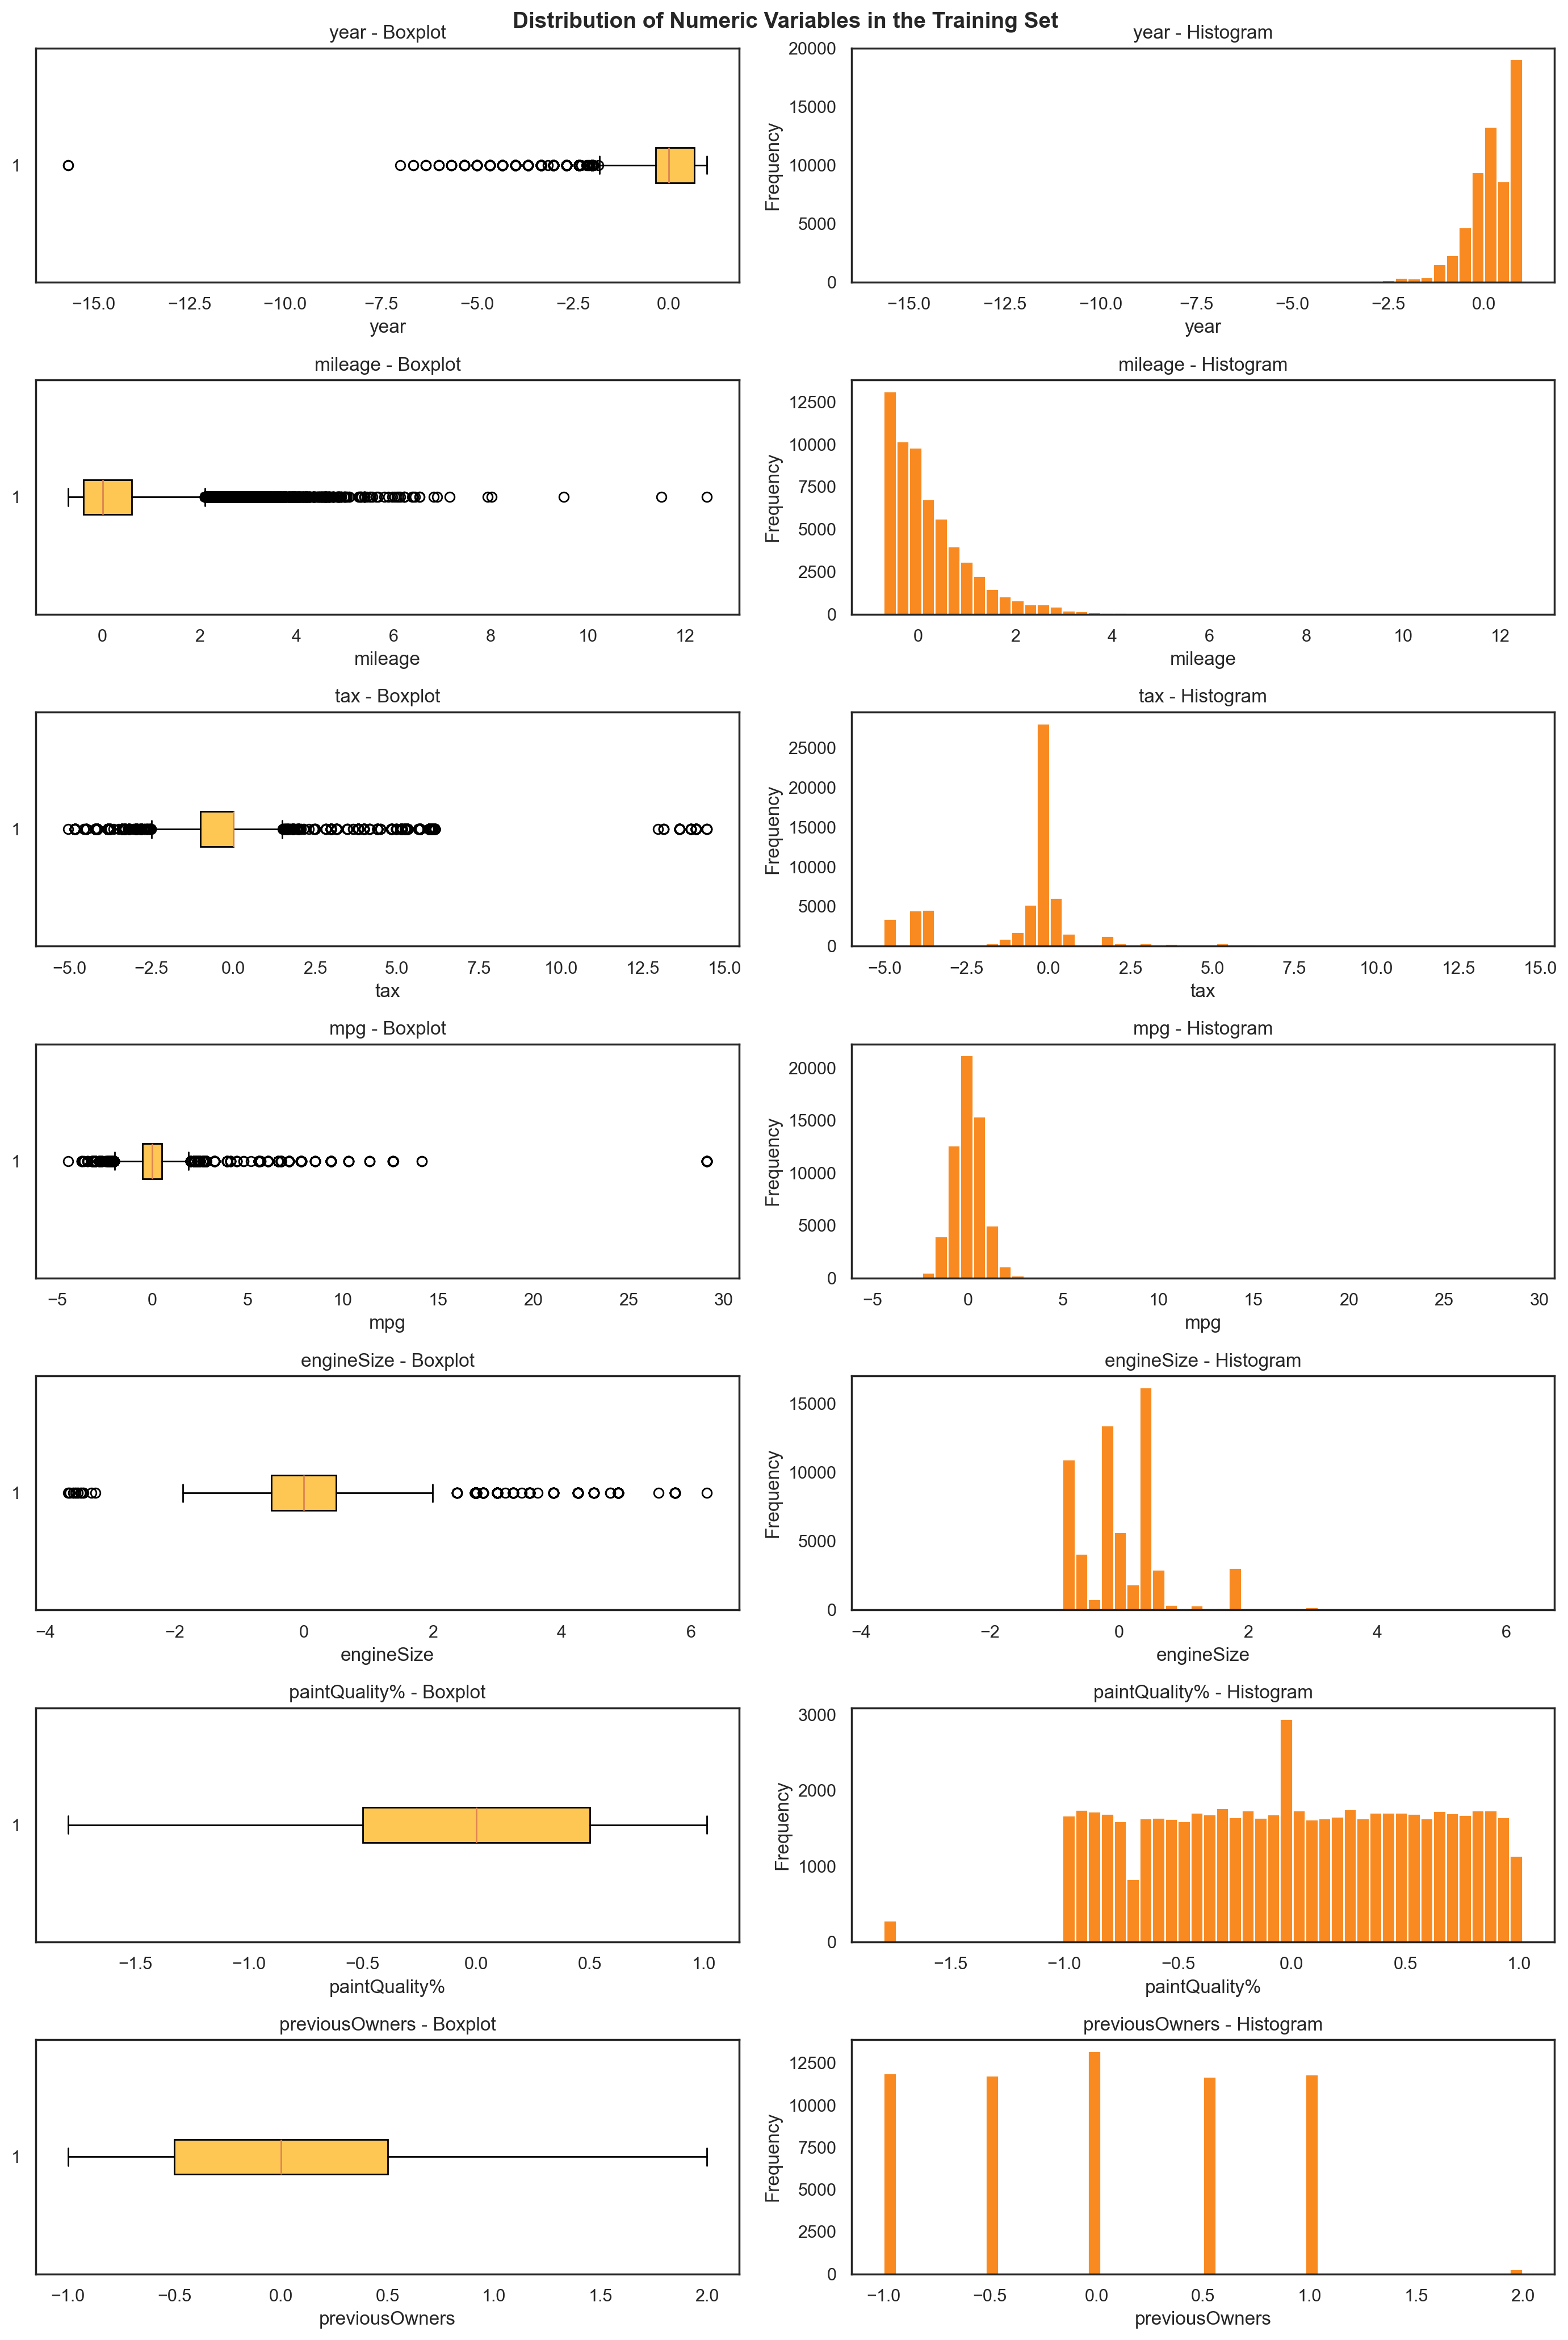

In [432]:
plot_box_hist(X_train, num_outliers, "in the Training Set")

In [433]:
# Get the indices of rows that are outliers by both IQR and MAD
indices_to_remove = indices_train['both']

# Calculate the impact of removing these rows
count_to_remove = len(indices_to_remove)
total_rows = len(X_train)
percentage_to_remove = (count_to_remove / total_rows) * 100 if total_rows > 0 else 0

print(f"\nIf we were to remove all rows identified as outliers by both the IQR and MAD methods:")
print(f"We would remove {count_to_remove} rows. This represents {percentage_to_remove:.2f}% of the entire dataset ({count_to_remove} out of {total_rows} rows).")


If we were to remove all rows identified as outliers by both the IQR and MAD methods:
We would remove 18683 rows. This represents 30.75% of the entire dataset (18683 out of 60763 rows).


Unlike numerical variables, where outliers are defined by extreme magnitudes, categorical outliers are identified by their low frequency of occurrence within the dataset.
Handling rare categories is important because they can negatively impact model performance by increasing the risk of overfitting, causing inconsistencies, and introducing noise rather than useful information.

For now, we will focus only on handling rare categories in the `model` variable, which exhibits the highest cardinality.
To address this, all rare `model` categories were grouped into a single, consolidated `'other'` category. The process was performed systematically:
1. We first calculated the frequency of each `(Brand, model)` combination using only the training set.
2. We then defined a minimum count and frequency threshold to determine which combinations were sufficiently common, resulting in a list of “kept” (frequent) models for each brand.
3. Finally, any `(Brand, model)` combination not included in this list was replaced by `'other'` except when either the brand or the model was `'unknown'`, in which case the original label was preserved.



In [434]:
def fit_keep_models_per_brand(train, brand_col="Brand", model_col="model",
                              min_count=20, min_freq=0.01):
    tmp = train[[brand_col, model_col]].copy()

    # Exclude 'unknown' entries
    tmp = tmp[~tmp[brand_col].isin(["unknown"])]
    tmp = tmp[~tmp[model_col].isin(["unknown"])]

    # Count combinations and calculate frequencies within each brand
    g = (tmp.groupby([brand_col, model_col], dropna=False)
           .size().rename("n").reset_index())
    g["brand_total"] = g.groupby(brand_col)["n"].transform("sum")
    g["freq"] = g["n"] / g["brand_total"]

    # Keep only sufficiently frequent combinations
    keep = g.loc[
        (g["n"] >= min_count) & (g["freq"] >= min_freq),
        [brand_col, model_col]
    ].copy()
    keep["keep"] = True

    return keep


def collapse_rare_models(df, keep_table, brand_col="Brand", model_col="model",
                         other_label="other"):
    # Save original index
    original_index = df.index

    out = df.copy()

    # Merge with keep_table (preserving all rows from df)
    out = out.merge(
        keep_table, how="left",
        on=[brand_col, model_col]
    )

    keep_mask = out["keep"].fillna(False)

    # Only replace rare models, skip if brand or model == 'unknown'
    mask_to_replace = (
        (~keep_mask) &
        (~out[brand_col].isin(["unknown", None, np.nan])) &
        (~out[model_col].isin(["unknown", None, np.nan]))
    )

    out.loc[mask_to_replace, model_col] = other_label

    # Restore original index
    out.index = original_index

    # Drop auxiliary column
    out = out.drop(columns=["keep"], errors="ignore")

    return out

In [435]:
"""
keep_tbl = fit_keep_models_per_brand(X_train, "Brand", "model",
                                     min_count=20, min_freq=0.01)

# apply to datasets
X_train = collapse_rare_models(X_train, keep_tbl, "Brand", "model")

# Check results
s = X_train["model"].astype("string").str.strip().str.lower()
print("other count (train):", int(s.eq("other").sum()),
      f"({s.eq('other').mean()*100:.2f}%)")
"""

'\nkeep_tbl = fit_keep_models_per_brand(X_train, "Brand", "model",\n                                     min_count=20, min_freq=0.01)\n\n# apply to datasets\nX_train = collapse_rare_models(X_train, keep_tbl, "Brand", "model")\n\n# Check results\ns = X_train["model"].astype("string").str.strip().str.lower()\nprint("other count (train):", int(s.eq("other").sum()),\n      f"({s.eq(\'other\').mean()*100:.2f}%)")\n'

In [ ]:
# This approach offers several significant advantages:
# *   **Noise Reduction:** By grouping, we consolidate the sparse information from rare categories into a new 'Other' category with a more substantial frequency.
# *   **Model Stability:** This prevents the model from creating unreliable rules for categories that barely appear. The new 'Other' category maybe can have sufficient data for the model to learn a more stable and generalizable pattern.
# *   **Handles New Categories:** Any new category that appears in the validation or test sets but was not seen during training is automatically mapped to 'Other', making the entire pipeline more robust.

# The primary trade-off is the loss of specific information from the individual rare categories. However, we consider this an acceptable and beneficial trade-off, as this granular information is more likely to be noise than a reliable signal.

In [436]:
"""
# use just the numeric columns (already scaled and imputed)
X_lof = X_train[numeric_cols].copy()

# apply LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.004)
lof.fit(X_lof)
lof_scores = lof.negative_outlier_factor_


# Define a threshold from LOF scores to classify outliers
threshold = -1.5 
outlier_indices_score = X_train.index[lof_scores < threshold]
print(f"Total number of outliers detected by LOF (Threshold < {threshold}): {len(outlier_indices_score)} ({len(outlier_indices_score) / len(X_train) * 100:.2f}%)") 

percent_extreme_outliers = (lof_scores < -2.0).sum() / len(lof_scores) * 100
percent_mild_outliers = ((lof_scores >= -2.0) & (lof_scores < -1.5)).sum() / len(lof_scores) * 100
percent_near_normal = ((lof_scores >= -1.5) & (lof_scores < -1.0)).sum() / len(lof_scores) * 100
percent_normal = (lof_scores >= -1.0).sum() / len(lof_scores) * 100
print(f"LOF Score < -2.0 (Extreme Outliers): {percent_extreme_outliers:.2f}%")
print(f"LOF Score [-2.0, -1.5) (Mild Outliers): {percent_mild_outliers:.2f}%")
print(f"LOF Score [-1.5, -1.0) (Near Normal): {percent_near_normal:.2f}%")
print(f"LOF Score >= -1.0 (Normal): {percent_normal:.2f}%")

# Reduce Dimensionality (t-SNE just for visualization)
X_lof_array = X_lof.values 

X_tsne = TSNE(n_components=2, 
              random_state=37, 
              perplexity=50,
              init='pca',
              n_jobs=-1).fit_transform(X_lof_array)

X_tsne = pd.DataFrame(X_tsne, index=X_lof.index, columns=['TSNE1', 'TSNE2'])

plt.figure(figsize=(12, 8))
inliers_tsne = X_tsne.loc[~X_tsne.index.isin(outlier_indices_score)]
plt.scatter(inliers_tsne['TSNE1'], inliers_tsne['TSNE2'], 
            color=palette[5], 
            s=50, 
            alpha=0.6,
            edgecolor='k',
            linewidth=0.5,
            label='Not Outliers')

# outliers given the threshold
outliers_tsne_score = X_tsne.loc[outlier_indices_score]
plt.scatter(outliers_tsne_score['TSNE1'], outliers_tsne_score['TSNE2'], 
            marker='X', 
            color=palette[0], 
            s=100, 
            label=f'Outliers (LOF < {threshold})', 
            zorder=2, 
            linewidths=1)

plt.title('Multivariate Outlier Detection with LOF (t-SNE Projection)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
"""

'\n# use just the numeric columns (already scaled and imputed)\nX_lof = X_train[numeric_cols].copy()\n\n# apply LOF\nlof = LocalOutlierFactor(n_neighbors=20, contamination=0.004)\nlof.fit(X_lof)\nlof_scores = lof.negative_outlier_factor_\n\n\n# Define a threshold from LOF scores to classify outliers\nthreshold = -1.5 \noutlier_indices_score = X_train.index[lof_scores < threshold]\nprint(f"Total number of outliers detected by LOF (Threshold < {threshold}): {len(outlier_indices_score)} ({len(outlier_indices_score) / len(X_train) * 100:.2f}%)") \n\npercent_extreme_outliers = (lof_scores < -2.0).sum() / len(lof_scores) * 100\npercent_mild_outliers = ((lof_scores >= -2.0) & (lof_scores < -1.5)).sum() / len(lof_scores) * 100\npercent_near_normal = ((lof_scores >= -1.5) & (lof_scores < -1.0)).sum() / len(lof_scores) * 100\npercent_normal = (lof_scores >= -1.0).sum() / len(lof_scores) * 100\nprint(f"LOF Score < -2.0 (Extreme Outliers): {percent_extreme_outliers:.2f}%")\nprint(f"LOF Score [-2.0

In [437]:
# Inverse transform (back to original scale)
X_train[numeric_cols] = scaler.inverse_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.inverse_transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.inverse_transform(X_test[numeric_cols])

# Round discrete variables to the nearest integer after imputation
for col in ['year', 'previousOwners']:
    X_train[col] = X_train[col].round().astype(int, errors='ignore')


In [438]:
#X_train = X_train.drop(outlier_indices_score, axis=0)
#y_train = y_train.drop(outlier_indices_score, axis=0)
#print(f"Shape of X_train after removing LOF outliers: {X_train.shape}")

<a id='7-features'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>7 | Feature Engineering</b></span>
    </h1>
</div>

### 7.1 Create New Features

#### _Categorical Combinations_

In [439]:
# Apply categorical combinations to ALL datasets
for df in [X_train, X_val, X_test]:
    # Brand-model combination
    df['brand_model'] = df['Brand'] + '_' + df['model']

print(f"Unique brand_model combinations in training: {X_train['brand_model'].nunique()}")
print("✅ Categorical combinations applied to all datasets")

Unique brand_model combinations in training: 192
✅ Categorical combinations applied to all datasets


#### _Brand Price Segments_

In [440]:
# Brand Price Segments (calculate stats from training set only to avoid data leakage)
y_price = y_train['price'].copy()

brand_stats = (
    X_train.join(y_price)
           .groupby('Brand')['price']
           .agg(['mean', 'median', 'std', 'count'])
           .round(2)
           .rename(columns={
               'mean': 'brand_mean_price',
               'median': 'brand_median_price',
               'std': 'brand_price_std',
               'count': 'brand_popularity'
           })
)

# Create brand segments based on mean price quantiles
p33, p67 = brand_stats['brand_mean_price'].quantile([0.33, 0.67])
brand_stats['brand_segment'] = pd.cut(
    brand_stats['brand_mean_price'],
    bins=[-np.inf, p33, p67, np.inf],
    labels=['budget', 'mid_range', 'luxury']
)

In [441]:
# Apply brand stats to ALL datasets (using training stats)
for df in [X_train, X_val, X_test]:
    # Join brand statistics
    for col in ['brand_price_std', 'brand_popularity', 'brand_segment']:
        df[col] = df['Brand'].map(brand_stats[col])
    
    # Fill missing values for unseen brands with global means/defaults
    df['brand_price_std'] = df['brand_price_std'].fillna(brand_stats['brand_price_std'].mean())
    df['brand_popularity'] = df['brand_popularity'].fillna(brand_stats['brand_popularity'].median())
    df['brand_segment'] = df['brand_segment'].fillna('mid_range')

print("✅ Brand statistics applied to all datasets")
print(f"   Columns added: brand_price_std, brand_popularity, brand_segment")

# Calculate model popularity from training set only
model_counts = X_train['model'].value_counts()

for df in [X_train, X_val, X_test]:
    df['model_popularity'] = df['model'].map(model_counts).fillna(0)

print(f"Unique models in training: {len(model_counts)}")
print("✅ Model popularity applied to all datasets")
print(f"   - model_popularity: count of model in training set")

✅ Brand statistics applied to all datasets
   Columns added: brand_price_std, brand_popularity, brand_segment
Unique models in training: 183
✅ Model popularity applied to all datasets
   - model_popularity: count of model in training set


#### _Age and Mileage Features_

In [442]:
# Calculate quantiles from training set only
q25_mileage = X_train['mileage'].quantile(0.25)
q75_mileage = X_train['mileage'].quantile(0.75)

print(f"Mileage Q25: {q25_mileage:.0f}, Q75: {q75_mileage:.0f}")

Mileage Q25: 7824, Q75: 32350


In [443]:
# Apply age and mileage features to ALL datasets
for df in [X_train, X_val, X_test]:
    # Age features (dataset is from 2020)
    # Ensure year is numeric first
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df["age"] = (2020 - df["year"]).round().astype("Int64")
    df["age_squared"] = df["age"] ** 2
    df['is_new_car'] = (df['age'] <= 1).astype(int)
    df['is_old_car'] = (df['age'] >= 10).astype(int)
    
    # Mileage features (using training quantiles)
    df['miles_per_year'] = df['mileage'] / (df['age'] + 1)  # +1 to avoid division by zero
    df['high_mileage'] = (df['mileage'] > q75_mileage).astype(int)
    df['low_mileage'] = (df['mileage'] < q25_mileage).astype(int)
    
    # Depreciation interaction
    df['age_mileage_interaction'] = df['age'] * df['mileage']

print("✅ Age and mileage features applied to all datasets")

✅ Age and mileage features applied to all datasets


#### _Engine and Efficiency Features_

In [444]:
# Apply engine and efficiency features to ALL datasets
for df in [X_train, X_val, X_test]:
    # Premium brand x engine size interaction
    df['premium_brand_engine_size_interaction'] = (
        (df['brand_segment'] == 'luxury').astype(int) * df['engineSize']
    )
    
    # Tax efficiency
    df['tax_per_engine'] = df['tax'] / (df['engineSize'] + 0.1)
    
    # Fuel efficiency per engine size
    df['mpg_per_liter'] = df['mpg'] / (df['engineSize'] + 0.1)

print("✅ Engine and efficiency features applied to all datasets")

✅ Engine and efficiency features applied to all datasets


### 7.3 Test Feature Independence

We will perform a **Chi-squared test** to detect **multicollinearity** among categorical variables.
This will help us identify which variables might be redundant and should potentially be removed, serving as an initial **feature selection step** that could be useful later in the modeling process.

In [445]:
# Test independence of categorical variables
def test_independence(X_1, X_2, alpha=0.05):
    data = pd.concat([X_1, X_2], axis=1).dropna()
    table = pd.crosstab(data.iloc[:, 0], data.iloc[:, 1])
    _, p, _, _ = stats.chi2_contingency(table.values)
    
    if p < alpha:
        return f"{X_1.name} ↔ {X_2.name}: DEPENDENT (p={p:.4f})"
    return f"{X_1.name} ↔ {X_2.name}: INDEPENDENT (p={p:.4f})"

X_train_cat = X_train.select_dtypes(exclude='number').copy()
X_train_cat['hasDamage'] = X_train['hasDamage']

for x1, x2 in combinations(X_train_cat.columns, 2):
    print(test_independence(X_train_cat[x1], X_train_cat[x2]))

Brand ↔ model: DEPENDENT (p=0.0000)
Brand ↔ transmission: DEPENDENT (p=0.0000)
Brand ↔ fuelType: DEPENDENT (p=0.0000)
Brand ↔ brand_model: DEPENDENT (p=0.0000)
Brand ↔ brand_segment: DEPENDENT (p=0.0000)
Brand ↔ hasDamage: INDEPENDENT (p=1.0000)
model ↔ transmission: DEPENDENT (p=0.0000)
model ↔ fuelType: DEPENDENT (p=0.0000)
model ↔ brand_model: DEPENDENT (p=0.0000)
model ↔ brand_segment: DEPENDENT (p=0.0000)
model ↔ hasDamage: INDEPENDENT (p=1.0000)
transmission ↔ fuelType: DEPENDENT (p=0.0000)
transmission ↔ brand_model: DEPENDENT (p=0.0000)
transmission ↔ brand_segment: DEPENDENT (p=0.0000)
transmission ↔ hasDamage: INDEPENDENT (p=1.0000)
fuelType ↔ brand_model: DEPENDENT (p=0.0000)
fuelType ↔ brand_segment: DEPENDENT (p=0.0000)
fuelType ↔ hasDamage: INDEPENDENT (p=1.0000)
brand_model ↔ brand_segment: DEPENDENT (p=0.0000)
brand_model ↔ hasDamage: INDEPENDENT (p=1.0000)
brand_segment ↔ hasDamage: INDEPENDENT (p=1.0000)


The `TestIndependence` function, removes missing values, builds a contingency table, and performs a Chi-square test (α = 0.05) to check whether two categorical variables are independent or redundant. It then selects all categorical columns from the training set and tests every pair to identify strongly related features.

We found that several variables are **redundant**, but we decided to keep most of them for now so they can be further assessed during the **feature selection** stage.
Here, we focus specifically on the redundancy between the categorical variables: **`Brand`** and **`model`** are highly correlated with each other, and both are also redundant with **`brand_model`** (and also other variables). Therefore, we chose to **keep  `brand_model` and `Brand`** for now.


Additionally, since we have already established that **`year`** and **`age`** are strongly correlated (as explained earlier), we will **remove `year`** to avoid duplication of information.


In [446]:
# Drop redundant columns
for d in [X_train, X_val, X_test]:
    d.drop(columns=['model', 'year'], errors='ignore', inplace=True)

print(f"Features after engineering: {X_train.shape[1]}")
print(f"Columns: {X_train.columns.tolist()}")

Features after engineering: 30
Columns: ['Brand', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage', 'mpg_is_missing', 'tax_is_missing', 'engineSize_is_missing', 'year_is_missing', 'brand_model', 'brand_price_std', 'brand_popularity', 'brand_segment', 'model_popularity', 'age', 'age_squared', 'is_new_car', 'is_old_car', 'miles_per_year', 'high_mileage', 'low_mileage', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'mpg_per_liter']


<a id='8-encoding'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>8 | Encoding & Scaling</b></span>
    </h1>
</div>

### 8.1 Target Encoding (High Cardinality)

For categorical variables, two different encoding techniques were used depending on their **cardinality**.

For the lower-cardinality features (such as `fuelType` and `transmission`, as well as any other categorical variables with a small number of distinct values), we applied **One-Hot Encoding (OHE)**. OHE is particularly well-suited for linear models and small-to-medium cardinality features. Its main drawback is the increase in dimensionality, which can become problematic when applied to variables with many categories, as it may raise computational cost and increase the risk of overfitting.

For high-cardinality features, specifically **`Brand`** and **`brand_model`**, we instead used **Target Encoding**. In this approach, each category is replaced with a numerical value equal to the (smoothed) mean target value — in our case, the average `price` for that brand or brand–model combination in the training data. This produces the features **`brand_mean_price`** and **`model_mean_price`**, which directly capture the empirical price signal associated with each category. Target Encoding is particularly powerful for price prediction because it embeds the relationship between category and target in a single, compact numerical feature, without inflating the number of columns.
However, Target Encoding comes with some limitations: it can make the model more sensitive to shifts between training and test distributions, and it reduces interpretability because the original categorical labels are no longer directly visible in the encoded features. 


In [447]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

# Separate high and low cardinality
high_cardinality_cols = ['Brand','brand_model']
low_cardinality_cols = [c for c in categorical_cols if c not in high_cardinality_cols]

Categorical columns: ['Brand', 'transmission', 'fuelType', 'brand_model', 'brand_segment']


In [448]:
# Target encoding for high-cardinality columns (captures price relationship)
# This is much more predictive than frequency encoding for price prediction
X_train_processed = X_train.copy()
X_val_processed = X_val.copy()
X_test_processed = X_test.copy()

# Initialize TargetEncoder with smoothing to prevent overfitting
target_encoder = TargetEncoder(smooth='auto', target_type='continuous')

# Fit on training data only
target_encoder.fit(X_train[high_cardinality_cols], y_train)

# Transform all datasets
train_encoded = target_encoder.transform(X_train[high_cardinality_cols])
val_encoded = target_encoder.transform(X_val[high_cardinality_cols])
test_encoded = target_encoder.transform(X_test[high_cardinality_cols])

# Add target encoded columns
for i, col in enumerate(high_cardinality_cols):
    new_col = f'{col}_target_enc'
    X_train_processed[new_col] = train_encoded[:, i]
    X_val_processed[new_col] = val_encoded[:, i]
    X_test_processed[new_col] = test_encoded[:, i]

# Drop original categorical columns
for df in [X_train_processed, X_val_processed, X_test_processed]:
    df.drop(columns=high_cardinality_cols, inplace=True, errors='ignore')

rename_cols = {
    'brand_model_target_enc': 'model_mean_price',
    'Brand_target_enc': 'brand_mean_price'
}

for df in [X_train_processed, X_val_processed, X_test_processed]:
    df.rename(columns=rename_cols, inplace=True)


print("✅ Target encoding applied ")
print(f"   brand_mean_price captures mean price per brand")
print(f"   model_mean_price captures mean price per model")

c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


✅ Target encoding applied 
   brand_mean_price captures mean price per brand
   model_mean_price captures mean price per model


### 8.2 One-Hot Encoding (Low Cardinality)

In [449]:
# One-hot encoding for low-cardinality columns
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
ohe.fit(X_train[low_cardinality_cols])

ohe_train = pd.DataFrame(ohe.transform(X_train[low_cardinality_cols]), 
                         columns=ohe.get_feature_names_out(), index=X_train.index)
ohe_val = pd.DataFrame(ohe.transform(X_val[low_cardinality_cols]), 
                       columns=ohe.get_feature_names_out(), index=X_val.index)
ohe_test = pd.DataFrame(ohe.transform(X_test[low_cardinality_cols]), 
                        columns=ohe.get_feature_names_out(), index=X_test.index)

for df in [X_train_processed, X_val_processed, X_test_processed]:
    df.drop(columns=low_cardinality_cols, inplace=True, errors='ignore')

X_train_final = pd.concat([X_train_processed, ohe_train], axis=1)
X_val_final = pd.concat([X_val_processed, ohe_val], axis=1)
X_test_final = pd.concat([X_test_processed, ohe_test], axis=1)

print(f"Shape after encoding: {X_train_final.shape}")

Shape after encoding: (60763, 38)


### 8.4 Final Scaling (PowerTransformer)

 PowerTransformer not only rescales the variables but also reduces skewness and stabilizes variance, bringing the data closer to a Gaussian distribution. This is particularly useful for numeric features with heavy tails, nonlinear patterns, or strictly positive domains, as it helps many models learn more effectively from the transformed feature space, therefore being useful in our case where numeric features contain extreme values and outliers are not removed.

Although the transformed values are less interpretable, this trade-off is acceptable since  the transformation improves predictive performance across our modeling pipeline.



In [450]:
# Apply PowerTransformer for final scaling
pt_scaler = PowerTransformer()

X_train_final = pd.DataFrame(
    pt_scaler.fit_transform(X_train_final), 
    columns=X_train_final.columns, 
    index=X_train_final.index
)
X_val_final = pd.DataFrame(
    pt_scaler.transform(X_val_final), 
    columns=X_val_final.columns, 
    index=X_val_final.index
)
X_test_final = pd.DataFrame(
    pt_scaler.transform(X_test_final), 
    columns=X_test_final.columns, 
    index=X_test_final.index
)

print("✅ PowerTransformer applied")
print(f"\nFinal features: {X_train_final.columns.tolist()}")

✅ PowerTransformer applied

Final features: ['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage', 'mpg_is_missing', 'tax_is_missing', 'engineSize_is_missing', 'year_is_missing', 'brand_price_std', 'brand_popularity', 'model_popularity', 'age', 'age_squared', 'is_new_car', 'is_old_car', 'miles_per_year', 'high_mileage', 'low_mileage', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'mpg_per_liter', 'brand_mean_price', 'model_mean_price', 'transmission_manual', 'transmission_other', 'transmission_semi auto', 'transmission_unknown', 'fuelType_electric', 'fuelType_hybrid', 'fuelType_other', 'fuelType_petrol', 'fuelType_unknown', 'brand_segment_luxury', 'brand_segment_mid_range']


<a id='9-export'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>9 | Export Preprocessed Data</b></span>
    </h1>
</div>

In [451]:
# Reset index for export
X_train_export = X_train_final.reset_index()
X_val_export = X_val_final.reset_index()
X_test_export = X_test_final.reset_index()
y_train_export = y_train.reset_index()
y_val_export = y_val.reset_index()

# Save to parquet
X_train_export.to_parquet("./project_data/X_train_scaled.parquet", engine="pyarrow", index=False)
X_val_export.to_parquet("./project_data/X_val_scaled.parquet", engine="pyarrow", index=False)
X_test_export.to_parquet("./project_data/X_test_scaled.parquet", engine="pyarrow", index=False)
y_train_export.to_parquet("./project_data/y_train.parquet", engine="pyarrow", index=False)
y_val_export.to_parquet("./project_data/y_val.parquet", engine="pyarrow", index=False)

# Also save the brand_model dictionary
brand_model_dic_norm.to_parquet("./project_data/brand_model_dic.parquet", engine="pyarrow", index=False)

print("✅ All datasets exported successfully!")
print(f"\nExported files:")
print(f"  - X_train_final.parquet: {X_train_export.shape}")
print(f"  - X_val_final.parquet: {X_val_export.shape}")
print(f"  - X_test_final.parquet: {X_test_export.shape}")
print(f"  - y_train.parquet: {y_train_export.shape}")
print(f"  - y_val.parquet: {y_val_export.shape}")

✅ All datasets exported successfully!

Exported files:
  - X_train_final.parquet: (60763, 39)
  - X_val_final.parquet: (15193, 39)
  - X_test_final.parquet: (32567, 39)
  - y_train.parquet: (60763, 2)
  - y_val.parquet: (15193, 2)
